In [2]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from skimage import transform
from skimage.measure import label, regionprops
import torch
import gc
from tqdm import tqdm
import logging

# MedSAM2
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

# Logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')


# -------------------------------------------------------
# Hilfsfunktionen
# -------------------------------------------------------
def show_mask(mask, ax, random_color=False):
    """Overlay Maske"""
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([251 / 255, 252 / 255, 30 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_box(box, ax):
    """Bounding Box zeichnen"""
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h,
                               edgecolor="blue", facecolor=(0, 0, 0, 0), lw=2))


def get_bounding_boxes_from_mask(mask2d):
    """Bounding Boxes aus einer 2D-Maske extrahieren"""
    boxes = []
    lab = label(mask2d.astype(np.uint8))
    for r in regionprops(lab):
        minr, minc, maxr, maxc = r.bbox
        boxes.append([minc, minr, maxc, maxr])  # [x_min, y_min, x_max, y_max]
    return boxes


def get_largest_seed_slice(mask_data):
    """Finde die Slice mit der größten Fläche der Maske"""
    max_area = 0
    seed_idx = None
    for s in range(mask_data.shape[2]):
        area = np.sum(mask_data[:, :, s] > 0)
        if area > max_area:
            max_area = area
            seed_idx = s
    return seed_idx


@torch.no_grad()
def medsam2_inference(predictor, image_rgb, box_1024):
    """Inference mit MedSAM2 für eine einzelne Box"""
    predictor.set_image((image_rgb * 255).astype(np.uint8))
    masks, scores, logits = predictor.predict(
        box=box_1024,
        multimask_output=False
    )
    return masks[0].astype(np.uint8)


# -------------------------------------------------------
# Gerät + Modell laden
# -------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.info(f"Verwende Gerät: {device}")

medsam_model = build_sam2(
    config_file="configs/sam2.1_hiera_t512.yaml",
    ckpt_path="checkpoints/MedSAM2_2411.pt",
    device=device
)
predictor = SAM2ImagePredictor(medsam_model)
logging.info("MedSAM2 model loaded successfully.")


# -------------------------------------------------------
# Hauptfunktion: Segmentierung mit Seed = größte Fläche
# -------------------------------------------------------
def process_images_with_largest_seed(images_dir, masks_dir, output_dir,
                                     resume_file=None, save_png=True):
    resume = resume_file is None
    mask_files = sorted([f for f in os.listdir(masks_dir)
                         if f.endswith(".nii") or f.endswith(".nii.gz")])

    with tqdm(total=len(mask_files), desc="Dateien", unit="Datei") as progress:
        for mask_file in mask_files:
            mask_path = os.path.join(masks_dir, mask_file)
            image_path = os.path.join(images_dir, mask_file)

            if not os.path.exists(image_path):
                logging.warning(f"Fehlendes Bild für Maske: {mask_file}")
                progress.update(1)
                continue

            if not resume and mask_file == resume_file:
                resume = True
            if not resume:
                progress.update(1)
                continue

            # NIfTI laden
            nifti_image = nib.load(image_path)
            nifti_mask = nib.load(mask_path)
            image_data = nifti_image.get_fdata()  # (H, W, Z)
            mask_data = nifti_mask.get_fdata()

            H, W, Z = image_data.shape

            # Seed-Slice = größte Fläche
            seed_slice_idx = get_largest_seed_slice(mask_data)
            logging.info(f"{mask_file}: größte Fläche bei Slice {seed_slice_idx}")

            seed_mask = (mask_data[:, :, seed_slice_idx] > 0).astype(np.uint8)
            boxes_xyxy = get_bounding_boxes_from_mask(seed_mask)

            if not boxes_xyxy:
                logging.warning(f"{mask_file}: keine Bounding Boxes gefunden – übersprungen.")
                progress.update(1)
                continue

            # Volumen vorbereiten
            image_volume = []
            for z in range(Z):
                img_resized = transform.resize(image_data[:, :, z], (1024, 1024),
                                               order=3, preserve_range=True, anti_aliasing=True)
                img_norm = (img_resized - img_resized.min()) / \
                           (img_resized.max() - img_resized.min() + 1e-8)
                image_volume.append(np.stack([img_norm] * 3, axis=-1).astype(np.float32))
            image_volume = np.array(image_volume, dtype=np.float32)

            # Boxen in 1024-Space skalieren
            scale = np.array([W, H, W, H], dtype=np.float32)
            boxes_1024 = []
            for (x1, y1, x2, y2) in boxes_xyxy:
                b = (np.array([x1, y1, x2, y2], dtype=np.float32) / scale) * 1024.0
                boxes_1024.append(b[None, :])

            # Segmentierung mit denselben Boxen für alle Slices
            mask_3d = []
            for z in range(Z):
                predictor.set_image((image_volume[z] * 255).astype(np.uint8))
                combined = np.zeros((1024, 1024), dtype=np.uint8)
                for b in boxes_1024:
                    seg = predictor.predict(box=b, multimask_output=False)[0]
                    seg = np.squeeze(seg).astype(np.uint8)
                    combined = np.maximum(combined, seg)
                mask_3d.append(combined)
            mask_3d = np.array(mask_3d, dtype=np.uint8)  # (Z,1024,1024)

            # Output-Ordner
            case_out_dir = os.path.join(output_dir,
                                        mask_file.replace(".nii.gz", "").replace(".nii", ""))
            os.makedirs(case_out_dir, exist_ok=True)

            # PNG speichern
            if save_png:
                for z in range(Z):
                    png_path = os.path.join(case_out_dir, f"slice_{z}_segmentation.png")
                    plt.imsave(png_path, mask_3d[z], cmap="gray")

                vis_file = os.path.join(case_out_dir,
                                        f"seed_slice_{seed_slice_idx}_visualization.png")
                fig, ax = plt.subplots(1, 2, figsize=(12, 6))
                ax[0].imshow(image_volume[seed_slice_idx][:, :, 0], cmap="gray")
                for b in boxes_1024:
                    show_box(b[0], ax[0])
                ax[0].set_title(f"Seed-Slice {seed_slice_idx} mit Bounding Boxes")
                ax[1].imshow(image_volume[seed_slice_idx][:, :, 0], cmap="gray")
                show_mask(mask_3d[seed_slice_idx], ax[1])
                ax[1].set_title("Segmentierung (Seed-Slice)")
                plt.savefig(vis_file)
                plt.close(fig)

            # Als NIfTI speichern
            nifti_out = nib.Nifti1Image(mask_3d.astype(np.uint8),
                                        affine=nifti_image.affine)
            nib.save(nifti_out, os.path.join(case_out_dir, "segmentation_3d.nii.gz"))

            del mask_3d, image_volume
            gc.collect()

            logging.info(f"Done with file {mask_file}")
            progress.update(1)


# -------------------------------------------------------
# Ausführung (Beispiel Heart-Daten)
# -------------------------------------------------------
images_dir = r"F:\Rawan_Masterarbeit\data\Heart\output_images"
masks_dir = r"F:\Rawan_Masterarbeit\data\Heart\output_masks"
output_dir = r"F:\Rawan_Masterarbeit\data\Heart\MedSAM2_results_seed_maxarea"
os.makedirs(output_dir, exist_ok=True)

process_images_with_largest_seed(
    images_dir=images_dir,
    masks_dir=masks_dir,
    output_dir=output_dir,
    resume_file="la_003.nii.gz",
    save_png=True
)


2025-08-17 16:47:10,442 - INFO - Verwende Gerät: cpu
2025-08-17 16:47:10,444 - INFO - Using device: cpu
2025-08-17 16:47:16,474 - INFO - Loaded checkpoint sucessfully
2025-08-17 16:47:16,892 - INFO - MedSAM2 model loaded successfully.
Dateien:   0%|                                                                               | 0/20 [00:00<?, ?Datei/s]2025-08-17 16:47:17,456 - INFO - la_003.nii.gz: größte Fläche bei Slice 22
2025-08-17 16:47:30,979 - INFO - For numpy array image, we assume (HxWxC) format
2025-08-17 16:47:31,846 - INFO - Computing image embeddings for the provided image...
2025-08-17 16:47:33,942 - INFO - Image embeddings computed.
2025-08-17 16:47:34,879 - INFO - For numpy array image, we assume (HxWxC) format
2025-08-17 16:47:34,921 - INFO - Computing image embeddings for the provided image...
2025-08-17 16:47:36,405 - INFO - Image embeddings computed.
2025-08-17 16:47:36,483 - INFO - For numpy array image, we assume (HxWxC) format
2025-08-17 16:47:36,498 - INFO - Com

2025-08-17 17:30:33,216 - INFO - Dice-Matrix gespeichert: dice_matrix_MedSAM2_seed_maxarea.csv


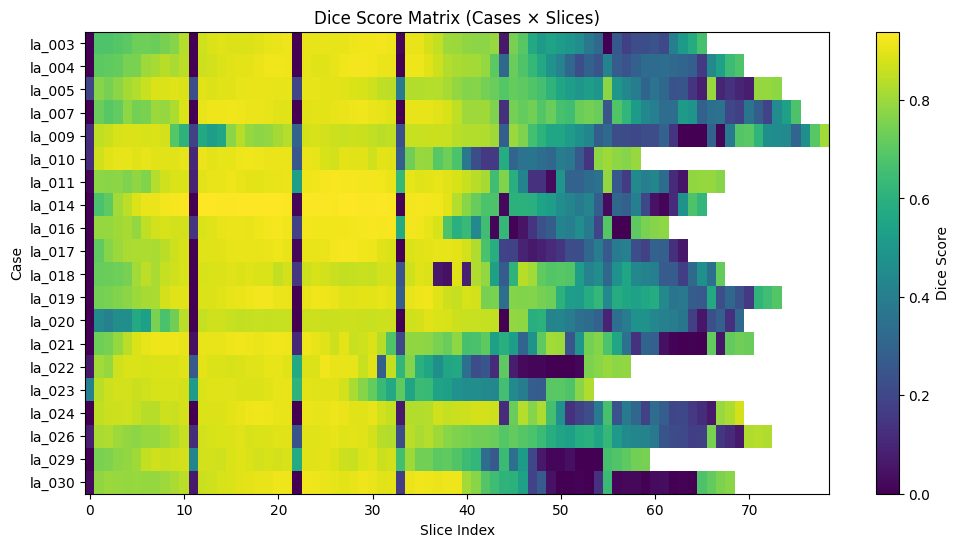

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
import pandas as pd
import logging

logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Dice Funktion
def dice_score(mask_gt, mask_pred):
    mask_gt = mask_gt.astype(bool)
    mask_pred = mask_pred.astype(bool)
    intersection = np.logical_and(mask_gt, mask_pred).sum()
    return (2. * intersection) / (mask_gt.sum() + mask_pred.sum() + 1e-8)

# Ordner
gt_dir   = r"F:\Rawan_Masterarbeit\data\Heart\output_masks_updated"  # Ground truth PNGs
pred_dir = r"F:\Rawan_Masterarbeit\data\Heart\MedSAM2_results_seed_maxarea"

# Alle Cases
cases = sorted(os.listdir(pred_dir))
dice_matrix = {}

for case in cases:
    case_path_pred = os.path.join(pred_dir, case)
    if not os.path.isdir(case_path_pred):
        continue
    
    # Alle vorhergesagten PNGs laden
    pred_files = sorted([f for f in os.listdir(case_path_pred) if f.endswith("_segmentation.png")])
    case_scores = []
    
    for pred_file in pred_files:
        # Slice-Index aus Dateiname holen
        slice_id = pred_file.split("_")[1]
        gt_file = f"{case}_slice_{int(slice_id)+1:02d}_segmentation.png"  # GT startet mit 01
        gt_path = os.path.join(gt_dir, gt_file)
        pred_path = os.path.join(case_path_pred, pred_file)

        if not os.path.exists(gt_path):
            logging.warning(f"Kein GT für {pred_file}")
            continue

        # Laden
        gt_mask   = imread(gt_path, as_gray=True) > 0.5
        pred_mask = imread(pred_path, as_gray=True) > 0.5

        # Dice
        score = dice_score(gt_mask, pred_mask)
        case_scores.append(score)
    
    dice_matrix[case] = case_scores

# In DataFrame speichern
df = pd.DataFrame.from_dict(dice_matrix, orient="index").fillna(np.nan)
df.to_csv("dice_matrix.csv")

logging.info("Dice-Matrix gespeichert: dice_matrix_MedSAM2_seed_maxarea.csv")

# Heatmap
plt.figure(figsize=(12, 6))
plt.imshow(df, cmap="viridis", aspect="auto")
plt.colorbar(label="Dice Score")
plt.title("Dice Score Matrix (Cases × Slices)")
plt.xlabel("Slice Index")
plt.ylabel("Case")
plt.yticks(ticks=np.arange(len(df.index)), labels=df.index)
plt.savefig("dice_matrix_heatmap_MedSAM2_seed_maxarea.png", dpi=300)
plt.show()


In [ ]:
import os
import numpy as np
import cv2
import logging
import csv
from concurrent.futures import ThreadPoolExecutor

# Logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Ordner mit GT (Ground Truth PNGs)  ⬅️ passe an, falls dein GT woanders liegt
gt_dir = r"F:\Rawan_Masterarbeit\data\Heart\output_masks_updated"

# Ordner mit Predictions (MedSAM2: zentrale Slice, mehrere Boxes → pro Case Unterordner)
pred_root = r"F:\Rawan_Masterarbeit\data\Heart\MedSAM2_results_seed_maxarea"

def dice_score(mask1, mask2):
    intersection = np.sum(mask1 * mask2)
    s = np.sum(mask1) + np.sum(mask2)
    return 1.0 if s == 0 else (2.0 * intersection) / s

def process_single_file(gt_filename):
    """
    Erwartetes GT-Muster: <case>_slice_<NN>_segmentation.png
    Beispiel: la_003_slice_01_segmentation.png
    Prediction: pred_root/<case>/slice_<N-1>_segmentation.png
    """
    if "_slice_" not in gt_filename:
        return None

    parts = gt_filename.split("_slice_")
    case_name = parts[0]                     # z.B. "la_003"
    slice_part = parts[1]                    # z.B. "01_segmentation.png"
    slice_num_str = slice_part.split("_")[0] # "01"
    try:
        slice_num_gt = int(slice_num_str)    # 1-basiert
    except ValueError:
        logging.warning(f"Konnte Slice-Zahl nicht parsen: {gt_filename}")
        return None

    slice_num_pred = slice_num_gt - 1        # 0-basiert für Predictions

    # Pfade bauen
    gt_path  = os.path.join(gt_dir, gt_filename)
    pred_path = os.path.join(pred_root, case_name, f"slice_{slice_num_pred}_segmentation.png")

    if not os.path.exists(pred_path):
        logging.warning(f"Prediction nicht gefunden: {pred_path}")
        return None

    # Laden
    gt_mask   = cv2.imread(gt_path,  cv2.IMREAD_GRAYSCALE)
    pred_mask = cv2.imread(pred_path, cv2.IMREAD_GRAYSCALE)
    if gt_mask is None or pred_mask is None:
        logging.warning(f"Konnte Datei nicht lesen: {gt_path} oder {pred_path}")
        return None

    # Binär
    gt_mask   = (gt_mask > 0).astype(np.uint8)
    pred_mask = (pred_mask > 0).astype(np.uint8)

    # Größen angleichen (Prediction → GT-Größe)
    if gt_mask.shape != pred_mask.shape:
        pred_mask = cv2.resize(pred_mask, (gt_mask.shape[1], gt_mask.shape[0]), interpolation=cv2.INTER_NEAREST)

    # Dice
    dice = dice_score(gt_mask, pred_mask)
    logging.info(f"{gt_filename}: Dice Score = {dice:.4f}")
    return gt_filename, dice

# Parallelisierte Verarbeitung
with ThreadPoolExecutor() as executor:
    futures = [executor.submit(process_single_file, f)
               for f in os.listdir(gt_dir) if f.lower().endswith(".png")]
    dice_scores = [res for res in (f.result() for f in futures) if res is not None]

# Ergebnisse speichern & Durchschnitt
if dice_scores:
    out_csv = r"F:\Rawan_Masterarbeit\data\Heart\dice_matrix_MedSAM2_seed_maxarea.csv"
    os.makedirs(os.path.dirname(out_csv), exist_ok=True)
    with open(out_csv, "w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(["GT Filename", "Dice Score"])
        writer.writerows(dice_scores)

    mean_dice = np.mean([score for _, score in dice_scores])
    logging.info(f"Durchschnittlicher Dice Score: {mean_dice:.4f}")
else:
    logging.info("Keine Dice Scores berechnet!")


2025-08-17 17:30:35,100 - INFO - la_003_slice_02_segmentation.png: Dice Score = 0.0000
2025-08-17 17:30:35,115 - INFO - la_003_slice_05_segmentation.png: Dice Score = 0.0627
2025-08-17 17:30:35,161 - INFO - la_003_slice_04_segmentation.png: Dice Score = 0.0174
2025-08-17 17:30:35,174 - INFO - la_003_slice_03_segmentation.png: Dice Score = 0.0000
2025-08-17 17:30:35,183 - INFO - la_003_slice_07_segmentation.png: Dice Score = 0.4042
2025-08-17 17:30:35,203 - INFO - la_003_slice_01_segmentation.png: Dice Score = 0.0000
2025-08-17 17:30:35,217 - INFO - la_003_slice_06_segmentation.png: Dice Score = 0.0010
2025-08-17 17:30:35,236 - INFO - la_003_slice_09_segmentation.png: Dice Score = 0.5760
2025-08-17 17:30:35,268 - INFO - la_003_slice_08_segmentation.png: Dice Score = 0.5112
2025-08-17 17:30:35,268 - INFO - la_003_slice_11_segmentation.png: Dice Score = 0.6815
2025-08-17 17:30:35,355 - INFO - la_003_slice_10_segmentation.png: Dice Score = 0.6647
2025-08-17 17:30:35,318 - INFO - la_003_sli

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import logging
import csv
import os

# Ergebnisse + Visualisierung
if dice_scores:
    # CSV speichern
    out_csv = r"F:\Rawan_Masterarbeit\data\Heart\dice_matrix_MedSAM2_seed_maxarea.csv"
    os.makedirs(os.path.dirname(out_csv), exist_ok=True)
    with open(out_csv, "w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(["Maskenname", "Dice Score"])
        writer.writerows(dice_scores)

    # Durchschnitt berechnen
    dice_values = [score for _, score in dice_scores]
    avg_dice = np.mean(dice_values)
    logging.info(f"\nDurchschnittlicher Dice Score: {avg_dice:.4f}")

    # Histogramm
    plt.figure(figsize=(8, 6))
    plt.hist(dice_values, bins=20, color='blue', alpha=0.7, edgecolor='black')
    plt.title('Distribution of Dice Scores (Heart – MedSAM2, Multi-Boxes)')
    plt.xlabel('Dice Score')
    plt.ylabel('Frequency')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Durchschnitt markieren
    plt.axvline(avg_dice, color='red', linestyle='dashed', linewidth=1.5, label=f'Durchschnitt: {avg_dice:.4f}')
    plt.legend()

    # Plot speichern + anzeigen
    out_png = r"F:\Rawan_Masterarbeit\data\Heart\dice_score_histogram_medsam2_seed_maxarea.png"
    plt.savefig(out_png)
    plt.show()

else:
    logging.info("Keine Dice Scores berechnet!")


In [2]:
# -*- coding: utf-8 -*-
import os
import json
import time
import csv
import gc
import logging
from typing import Optional, List

import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from skimage import transform
from skimage.measure import label, regionprops
import torch
from tqdm import tqdm

# ================== MedSAM2 ==================
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

# ================== Logging ==================
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# ================== Visualisierung ==================
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([251 / 255, 252 / 255, 30 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor="blue", facecolor=(0, 0, 0, 0), lw=2))

# ================== Hilfsfunktionen ==================
def get_bounding_boxes_from_mask(mask2d: np.ndarray) -> List[List[int]]:
    boxes = []
    lab = label(mask2d.astype(np.uint8))
    for r in regionprops(lab):
        minr, minc, maxr, maxc = r.bbox
        boxes.append([minc, minr, maxc, maxr])  # [x_min, y_min, x_max, y_max]
    return boxes

def get_largest_seed_slice(mask_data: np.ndarray) -> Optional[int]:
    max_area, seed_idx = 0, None
    for s in range(mask_data.shape[2]):
        area = int(np.sum(mask_data[:, :, s] > 0))
        if area > max_area:
            max_area, seed_idx = area, s
    return seed_idx

def _fmt(sec: float) -> str:
    h, r = divmod(sec, 3600)
    m, s = divmod(r, 60)
    return f"{int(h):02d}:{int(m):02d}:{s:05.2f}"

def _sum_seconds_from_csv(csv_path: str) -> float:
    if not os.path.exists(csv_path):
        return 0.0
    total = 0.0
    try:
        with open(csv_path, "r", encoding="utf-8") as f:
            reader = csv.DictReader(f)
            if not reader.fieldnames or "seconds" not in reader.fieldnames:
                return 0.0
            for row in reader:
                try:
                    total += float(row["seconds"])
                except Exception:
                    continue
    except Exception as e:
        logging.warning(f"Konnte CSV nicht auswerten ({csv_path}): {e}")
    return total

def _load_runtime_state(state_path: str) -> dict:
    if os.path.exists(state_path):
        try:
            with open(state_path, "r", encoding="utf-8") as f:
                return json.load(f)
        except Exception as e:
            logging.warning(f"Konnte Runtime-State nicht lesen: {e}")
    return {"sessions": [], "total_elapsed_sec": 0.0}

def _save_runtime_state(state_path: str, state: dict):
    with open(state_path, "w", encoding="utf-8") as f:
        json.dump(state, f, indent=2)

def time_run_accumulate(func, state_path: str, seed_timing_csv: str, *args, **kwargs):
    """
    Misst Wall-Clock des gesamten Laufs und akkumuliert in state_path.
    Loggt zusätzlich die Summe der Slice-Zeiten aus seed_timing_csv.
    """
    state = _load_runtime_state(state_path)
    start_perf = time.perf_counter()
    start_wall = time.time()
    logging.info("==== Starte Laufzeitmessung (akkumuliert) ====")
    try:
        return func(*args, **kwargs)
    finally:
        elapsed = time.perf_counter() - start_perf
        end_wall = time.time()

        state["sessions"].append({"start": start_wall, "end": end_wall, "elapsed_sec": elapsed})
        state["total_elapsed_sec"] = float(state.get("total_elapsed_sec", 0.0)) + float(elapsed)
        _save_runtime_state(state_path, state)

        msg1 = f"Aktueller Run: {_fmt(elapsed)} | Akkumuliert (Wall-Clock): {_fmt(state['total_elapsed_sec'])}"
        logging.info(msg1)

        total_csv_sec = _sum_seconds_from_csv(seed_timing_csv)
        msg2 = f"Akkumulierte Gesamtlaufzeit (aus CSV, alle Neustarts): {_fmt(total_csv_sec)}"
        logging.info(msg2)

        log_dir = os.path.dirname(seed_timing_csv) if seed_timing_csv else "."
        with open(os.path.join(log_dir, "runtime_log_medsam2_heart.txt"), "a", encoding="utf-8") as f:
            f.write(msg1 + "\n")
            f.write(msg2 + "\n")

# ================== Gerät & Modell ==================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.info(f"Verwende Gerät: {device}")

medsam_model = build_sam2(
    config_file="configs/sam2.1_hiera_t512.yaml",
    # ckpt_path="checkpoints/MedSAM2_2411.pt",
    ckpt_path=r"F:\Rawan_Masterarbeit\MedSAM2_old\checkpoints\MedSAM2_2411.pt",
    device=device
)
predictor = SAM2ImagePredictor(medsam_model)
logging.info("MedSAM2 model loaded successfully.")

# ================== Hauptpipeline (Heart, mehrere Boxen) ==================
@torch.no_grad()
def process_images_with_largest_seed(
    images_dir: str,
    masks_dir: str,
    output_dir: str,
    timing_csv: str,
    resume_file: Optional[str] = None,
    save_png: bool = True
):
    """
    - Seed-Slice = größte GT-Fläche
    - Extrahiert ALLE Bounding-Boxes der Seed-Slice und nutzt sie als Prompts
      für jede Slice des Volumens.
    - Schreibt pro Slice die Segmentierungszeit (set_image + predict[alle Boxen]) nach timing_csv.
    """
    os.makedirs(output_dir, exist_ok=True)

    # CSV Header
    if not os.path.exists(timing_csv):
        with open(timing_csv, "w", newline="", encoding="utf-8") as fcsv:
            csv.writer(fcsv).writerow(["file", "slice_idx", "seconds"])

    resume = resume_file is None
    mask_files = sorted([f for f in os.listdir(masks_dir) if f.endswith((".nii", ".nii.gz"))])

    with tqdm(total=len(mask_files), desc="Dateien", unit="Datei") as progress:
        for mask_file in mask_files:
            mask_path = os.path.join(masks_dir, mask_file)
            image_path = os.path.join(images_dir, mask_file)

            if not os.path.exists(image_path):
                logging.warning(f"Fehlendes Bild für Maske: {mask_file}")
                progress.update(1)
                continue

            if not resume and mask_file == resume_file:
                resume = True
            if not resume:
                progress.update(1)
                continue

            # -------- NIfTI laden --------
            nifti_image = nib.load(image_path)
            nifti_mask  = nib.load(mask_path)
            image_data = nifti_image.get_fdata(dtype=np.float32)  # (H,W,Z)
            mask_data  = nifti_mask.get_fdata(dtype=np.float32)   # (H,W,Z)
            H, W, Z = image_data.shape

            # -------- Seed-Slice bestimmen --------
            seed_slice_idx = get_largest_seed_slice(mask_data)
            if seed_slice_idx is None:
                logging.warning(f"{mask_file}: keine GT gefunden – übersprungen.")
                progress.update(1)
                continue
            logging.info(f"{mask_file}: größte Fläche bei Slice {seed_slice_idx}")

            # -------- Bounding-Boxes aus Seed --------
            seed_mask = (mask_data[:, :, seed_slice_idx] > 0).astype(np.uint8)
            boxes_xyxy = get_bounding_boxes_from_mask(seed_mask)
            if not boxes_xyxy:
                logging.warning(f"{mask_file}: keine Bounding Boxes – übersprungen.")
                progress.update(1)
                continue

            # -------- Volumen vorbereiten (Z,1024,1024,3) --------
            image_volume = []
            for z in range(Z):
                img_resized = transform.resize(
                    image_data[:, :, z],
                    (1024, 1024),
                    order=3, preserve_range=True, anti_aliasing=True
                )
                ptp = float(img_resized.max() - img_resized.min())
                img_norm = (img_resized - img_resized.min()) / (ptp + 1e-8)
                image_volume.append(np.stack([img_norm] * 3, axis=-1).astype(np.float32))
            image_volume = np.asarray(image_volume, dtype=np.float32)

            # -------- Boxen in 1024-Space --------
            scale = np.array([W, H, W, H], dtype=np.float32)
            boxes_1024 = []
            for (x1, y1, x2, y2) in boxes_xyxy:
                b = (np.array([x1, y1, x2, y2], dtype=np.float32) / scale) * 1024.0
                boxes_1024.append(b[None, :])

            # -------- Segmentierung (pro Slice alle Boxen) --------
            mask_3d = []
            with tqdm(total=Z, desc=f"Slices in {mask_file}", unit="Slice") as prog_slices:
                for z in range(Z):
                    t0 = time.perf_counter()
                    try:
                        predictor.set_image((image_volume[z] * 255).astype(np.uint8))
                        combined = np.zeros((1024, 1024), dtype=np.uint8)

                        # mehrfach-Box-Prompting
                        for b in boxes_1024:
                            masks, scores, logits = predictor.predict(
                                box=b.squeeze().tolist(),
                                multimask_output=False
                            )
                            seg = np.squeeze(masks[0]).astype(np.uint8)
                            combined = np.maximum(combined, seg)

                        mask_3d.append(combined)
                    except Exception as e:
                        logging.error(f"Fehler bei {mask_file} Slice {z}: {e}")
                        mask_3d.append(np.zeros((1024, 1024), dtype=np.uint8))
                    finally:
                        elapsed_slice = time.perf_counter() - t0  # reine Segmentierung pro Slice
                        with open(timing_csv, "a", newline="", encoding="utf-8") as fcsv:
                            csv.writer(fcsv).writerow([mask_file, z, f"{elapsed_slice:.4f}"])
                        prog_slices.update(1)

            mask_3d = np.asarray(mask_3d, dtype=np.uint8)  # (Z,1024,1024)

            # -------- Speichern --------
            case_out_dir = os.path.join(
                output_dir, mask_file.replace(".nii.gz", "").replace(".nii", "")
            )
            os.makedirs(case_out_dir, exist_ok=True)

            if save_png:
                for z in range(Z):
                    png_path = os.path.join(case_out_dir, f"slice_{z}_segmentation.png")
                    plt.imsave(png_path, mask_3d[z], cmap="gray")

                vis_file = os.path.join(case_out_dir, f"seed_slice_{seed_slice_idx}_visualization.png")
                fig, ax = plt.subplots(1, 2, figsize=(12, 6))
                ax[0].imshow(image_volume[seed_slice_idx][:, :, 0], cmap="gray")
                for b in boxes_1024:
                    show_box(b[0], ax[0])
                ax[0].set_title(f"Seed-Slice {seed_slice_idx} mit Bounding Boxes")
                ax[1].imshow(image_volume[seed_slice_idx][:, :, 0], cmap="gray")
                show_mask(mask_3d[seed_slice_idx], ax[1])
                ax[1].set_title("Segmentierung (Seed-Slice)")
                for a in ax: a.axis('off')
                plt.savefig(vis_file, dpi=150, bbox_inches="tight")
                plt.close(fig)

            # NIfTI als (Z,1024,1024) im gleichen Affine wie Original speichern
            nifti_out = nib.Nifti1Image(mask_3d.astype(np.uint8), affine=nifti_image.affine)
            nib.save(nifti_out, os.path.join(case_out_dir, "segmentation_3d.nii.gz"))

            # Cleanup
            del mask_3d, image_volume
            gc.collect()
            if device.type == "cuda":
                torch.cuda.empty_cache()

            logging.info(f"Done with file {mask_file}")
            progress.update(1)

# ================== Ausführung (Heart) ==================
if __name__ == "__main__":
    images_dir = r"F:\Rawan_Masterarbeit\data\Heart\output_images"
    masks_dir  = r"F:\Rawan_Masterarbeit\data\Heart\output_masks"
    output_dir = r"F:\Rawan_Masterarbeit\data\Heart\MedSAM2_results_seed_maxarea_with_run_time"
    os.makedirs(output_dir, exist_ok=True)

    timing_csv    = os.path.join(output_dir, "timing_per_slice.csv")
    runtime_state = os.path.join(output_dir, "runtime_state_heart.json")

    manual_resume_file = "la_003.nii.gz"  # oder None

    # Wall-Clock + CSV-basierte echte Segmentierzeit (Summe der Slice-Zeiten)
    time_run_accumulate(
        process_images_with_largest_seed,
        runtime_state,
        seed_timing_csv=timing_csv,
        images_dir=images_dir,
        masks_dir=masks_dir,
        output_dir=output_dir,
        timing_csv=timing_csv,   # wichtig: hier landen die Slice-Zeiten
        resume_file=manual_resume_file,
        save_png=True
    )

    # Optional: Gesamtsumme aus CSV separat loggen
    total_csv_sec = _sum_seconds_from_csv(timing_csv)
    logging.info(f"[FINAL] Gesamtlaufzeit aus CSV (alle Neustarts): {_fmt(total_csv_sec)}")


2025-09-14 14:21:52,876 - INFO - Verwende Gerät: cpu
2025-09-14 14:21:52,879 - INFO - Using device: cpu
2025-09-14 14:21:58,554 - INFO - Loaded checkpoint sucessfully
2025-09-14 14:21:59,554 - INFO - MedSAM2 model loaded successfully.
2025-09-14 14:21:59,619 - INFO - ==== Starte Laufzeitmessung (akkumuliert) ====
Dateien:   0%|                                                                               | 0/20 [00:00<?, ?Datei/s]2025-09-14 14:22:00,430 - INFO - la_003.nii.gz: größte Fläche bei Slice 22

Slices in la_003.nii.gz:   0%|                                                               | 0/66 [00:00<?, ?Slice/s]2025-09-14 14:22:09,322 - INFO - For numpy array image, we assume (HxWxC) format
2025-09-14 14:22:10,117 - INFO - Computing image embeddings for the provided image...
2025-09-14 14:22:11,890 - INFO - Image embeddings computed.

Slices in la_003.nii.gz:   2%|▊                                                      | 1/66 [00:02<03:04,  2.84s/Slice]2025-09-14 14:22:12,183 

Wichtiges Detail:

Boxen werden als (1,4) an predictor.predict übergeben.

Falls die „Index-Mitte“ keine Maske enthält, wählt der Code automatisch die Slice mit der größten Fläche als Seed (damit du keine komplett schwarzen Masken bekommst).

Ausgabe: PNGs je Slice, Seed-Visualisierung, sowie segmentation_3d.nii.gz pro Fall.

Viel Erfolg!

In [3]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from skimage import transform
from skimage.measure import label, regionprops
import torch
import gc
from tqdm import tqdm
import logging

# MedSAM2 Imports
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

# Logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Visualisierung
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([251 / 255, 252 / 255, 30 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor="blue", facecolor=(0, 0, 0, 0), lw=2))

# Mehrere Bounding Boxes aus einer 2D-Maske
def get_bounding_boxes_from_mask(mask2d, H, W, pad_ratio=0.02):
    boxes = []
    lab = label(mask2d.astype(np.uint8))
    pad_x = max(1, int(pad_ratio * W))
    pad_y = max(1, int(pad_ratio * H))
    for r in regionprops(lab):
        minr, minc, maxr, maxc = r.bbox  # (row, col)
        x1 = max(0, minc - pad_x)
        y1 = max(0, minr - pad_y)
        x2 = min(W - 1, maxc + pad_x)
        y2 = min(H - 1, maxr + pad_y)
        boxes.append([x1, y1, x2, y2])   # [x_min, y_min, x_max, y_max]
    return boxes

# Gerät
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.info(f"Verwende Gerät: {device}")

# Modell laden
medsam_model = build_sam2(
    config_file="configs/sam2.1_hiera_t512.yaml",
    ckpt_path="checkpoints/MedSAM2_2411.pt",
    device=device
)
predictor = SAM2ImagePredictor(medsam_model)
logging.info("MedSAM2 model loaded successfully.")

# Hauptfunktion: NUR mittlere Slice liefert mehrere Boxes, die für alle Slices benutzt werden
@torch.no_grad()
def process_images_with_propagation(images_dir, masks_dir, output_dir, resume_file=None, save_png=True):
    resume = resume_file is None
    mask_files = sorted([f for f in os.listdir(masks_dir) if f.endswith(".nii") or f.endswith(".nii.gz")])

    with tqdm(total=len(mask_files), desc="Dateien", unit="Datei") as progress:
        for mask_file in mask_files:
            mask_path  = os.path.join(masks_dir,  mask_file)
            image_path = os.path.join(images_dir, mask_file)

            if not os.path.exists(image_path):
                logging.warning(f"Fehlendes Bild für Maske: {mask_file}")
                progress.update(1); continue

            if not resume and mask_file == resume_file:
                resume = True
            if not resume:
                progress.update(1); continue

            # NIfTI laden
            nifti_image = nib.load(image_path)
            nifti_mask  = nib.load(mask_path)
            image_data  = nifti_image.get_fdata()  # (H,W,Z)
            mask_data   = nifti_mask.get_fdata()

            H, W, Z = image_data.shape

            # Mittlere Slice (Indexmitte). Falls dort kein Label vorhanden: Fallback = größte Fläche.
            central_slice_idx = Z // 2
            if np.sum(mask_data[:, :, central_slice_idx] > 0) == 0:
                slice_areas = [np.sum(mask_data[:, :, s] > 0) for s in range(Z)]
                central_slice_idx = int(np.argmax(slice_areas))
                logging.info(f"{mask_file}: Mitte leer → nutze Slice mit größter Fläche: {central_slice_idx}")
            else:
                logging.info(f"{mask_file}: zentrale Slice (Index): {central_slice_idx}")

            # Mehrere Bounding Boxes nur aus der mittleren Slice holen
            seed_mask   = (mask_data[:, :, central_slice_idx] > 0).astype(np.uint8)
            boxes_xyxy  = get_bounding_boxes_from_mask(seed_mask, H, W, pad_ratio=0.02)

            if not boxes_xyxy:
                logging.warning(f"{mask_file}: keine Bounding Boxes in Seed-Slice gefunden – übersprungen.")
                progress.update(1); continue

            # Vorbereiten: Bild-Volumen auf 1024 normalisieren
            image_volume = []
            for z in range(Z):
                img_resized = transform.resize(image_data[:, :, z], (1024, 1024),
                                               order=3, preserve_range=True, anti_aliasing=True)
                img_norm = (img_resized - img_resized.min()) / (img_resized.max() - img_resized.min() + 1e-8)
                image_volume.append(np.stack([img_norm] * 3, axis=-1).astype(np.float32))
            image_volume = np.array(image_volume, dtype=np.float32)

            # Boxen in 1024-Koordinaten vorbereiten
            scale = np.array([W, H, W, H], dtype=np.float32)
            boxes_1024 = []
            for (x1, y1, x2, y2) in boxes_xyxy:
                b = (np.array([x1, y1, x2, y2], dtype=np.float32) / scale) * 1024.0
                boxes_1024.append(b[None, :])  # (1,4)
            # 3D Segmentierung: dieselben (mehreren) Boxes für jede Slice anwenden
            mask_3d = []
            for z in range(Z):
                predictor.set_image((image_volume[z] * 255).astype(np.uint8))
                combined = np.zeros((1024, 1024), dtype=np.uint8)
                for b in boxes_1024:
                    seg = predictor.predict(box=b, multimask_output=False)[0]
                    seg = np.squeeze(seg).astype(np.uint8)
                    combined = np.maximum(combined, seg)
                mask_3d.append(combined)
            mask_3d = np.array(mask_3d, dtype=np.uint8)  # (Z,1024,1024)

            # Ergebnisse speichern
            case_out_dir = os.path.join(output_dir, mask_file.replace(".nii.gz", "").replace(".nii", ""))
            os.makedirs(case_out_dir, exist_ok=True)

            # PNG-Slices optional speichern
            if save_png:
                for z in range(Z):
                    png_path = os.path.join(case_out_dir, f"slice_{z}_segmentation.png")
                    plt.imsave(png_path, mask_3d[z], cmap="gray")

                # Visualisierung des zentralen Slice
                vis_file = os.path.join(case_out_dir, f"central_slice_{central_slice_idx}_visualization.png")
                fig, ax = plt.subplots(1, 2, figsize=(12, 6))
                ax[0].imshow(image_volume[central_slice_idx][:, :, 0], cmap="gray")
                for b in boxes_1024:
                    show_box(b[0], ax[0])
                ax[0].set_title(f"Seed-Slice {central_slice_idx} mit Bounding Boxes")
                ax[1].imshow(image_volume[central_slice_idx][:, :, 0], cmap="gray")
                show_mask(mask_3d[central_slice_idx], ax[1])
                ax[1].set_title("Segmentierung (Seed-Slice)")
                plt.savefig(vis_file); plt.close(fig)

            # Maske als NIfTI speichern
            nifti_out = nib.Nifti1Image(mask_3d.astype(np.uint8), affine=nifti_image.affine)
            nib.save(nifti_out, os.path.join(case_out_dir, "segmentation_3d.nii.gz"))

            del mask_3d, image_volume
            gc.collect()

            logging.info(f"Done with file {mask_file}")
            progress.update(1)

# Ordner definieren (HEART!)
images_dir = r"F:\Rawan_Masterarbeit\data\Heart\output_images"
masks_dir  = r"F:\Rawan_Masterarbeit\data\Heart\output_masks"
output_dir = r"F:\Rawan_Masterarbeit\data\Heart\MedSAM2_results_central_slice_multi_boxes"
os.makedirs(output_dir, exist_ok=True)

# Starten
process_images_with_propagation(
    images_dir=images_dir,
    masks_dir=masks_dir,
    output_dir=output_dir,
    resume_file="la_003.nii.gz",   # oder None
    save_png=True
)


2025-08-16 07:34:46,792 - INFO - Verwende Gerät: cpu
2025-08-16 07:34:46,795 - INFO - Using device: cpu
2025-08-16 07:34:52,044 - INFO - Loaded checkpoint sucessfully
2025-08-16 07:34:52,074 - INFO - MedSAM2 model loaded successfully.
Dateien:   0%|                                                                               | 0/20 [00:00<?, ?Datei/s]2025-08-16 07:34:52,645 - INFO - la_003.nii.gz: zentrale Slice (Index): 33
2025-08-16 07:35:08,319 - INFO - For numpy array image, we assume (HxWxC) format
2025-08-16 07:35:09,350 - INFO - Computing image embeddings for the provided image...
2025-08-16 07:35:12,441 - INFO - Image embeddings computed.
2025-08-16 07:35:13,188 - INFO - For numpy array image, we assume (HxWxC) format
2025-08-16 07:35:13,237 - INFO - Computing image embeddings for the provided image...
2025-08-16 07:35:14,909 - INFO - Image embeddings computed.
2025-08-16 07:35:15,087 - INFO - For numpy array image, we assume (HxWxC) format
2025-08-16 07:35:15,134 - INFO - Com

2025-08-16 08:21:59,640 - INFO - Dice-Matrix gespeichert: dice_matrix.csv


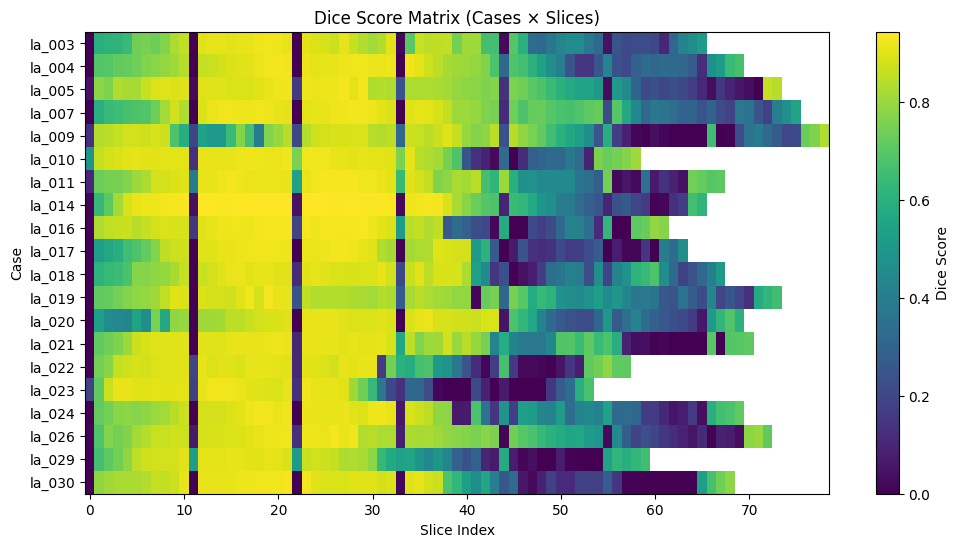

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
import pandas as pd
import logging

logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Dice Funktion
def dice_score(mask_gt, mask_pred):
    mask_gt = mask_gt.astype(bool)
    mask_pred = mask_pred.astype(bool)
    intersection = np.logical_and(mask_gt, mask_pred).sum()
    return (2. * intersection) / (mask_gt.sum() + mask_pred.sum() + 1e-8)

# Ordner
gt_dir   = r"F:\Rawan_Masterarbeit\data\Heart\output_masks_updated"  # Ground truth PNGs
pred_dir = r"F:\Rawan_Masterarbeit\data\Heart\MedSAM2_results_central_slice_multi_boxes"

# Alle Cases
cases = sorted(os.listdir(pred_dir))
dice_matrix = {}

for case in cases:
    case_path_pred = os.path.join(pred_dir, case)
    if not os.path.isdir(case_path_pred):
        continue
    
    # Alle vorhergesagten PNGs laden
    pred_files = sorted([f for f in os.listdir(case_path_pred) if f.endswith("_segmentation.png")])
    case_scores = []
    
    for pred_file in pred_files:
        # Slice-Index aus Dateiname holen
        slice_id = pred_file.split("_")[1]
        gt_file = f"{case}_slice_{int(slice_id)+1:02d}_segmentation.png"  # GT startet mit 01
        gt_path = os.path.join(gt_dir, gt_file)
        pred_path = os.path.join(case_path_pred, pred_file)

        if not os.path.exists(gt_path):
            logging.warning(f"Kein GT für {pred_file}")
            continue

        # Laden
        gt_mask   = imread(gt_path, as_gray=True) > 0.5
        pred_mask = imread(pred_path, as_gray=True) > 0.5

        # Dice
        score = dice_score(gt_mask, pred_mask)
        case_scores.append(score)
    
    dice_matrix[case] = case_scores

# In DataFrame speichern
df = pd.DataFrame.from_dict(dice_matrix, orient="index").fillna(np.nan)
df.to_csv("dice_matrix.csv")

logging.info("Dice-Matrix gespeichert: dice_matrix.csv")

# Heatmap
plt.figure(figsize=(12, 6))
plt.imshow(df, cmap="viridis", aspect="auto")
plt.colorbar(label="Dice Score")
plt.title("Dice Score Matrix (Cases × Slices)")
plt.xlabel("Slice Index")
plt.ylabel("Case")
plt.yticks(ticks=np.arange(len(df.index)), labels=df.index)
plt.savefig("dice_matrix_heatmap.png", dpi=300)
plt.show()


In [5]:
import os
import numpy as np
import cv2
import logging
import csv
from concurrent.futures import ThreadPoolExecutor

# Logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Ordner mit GT (Ground Truth PNGs)  ⬅️ passe an, falls dein GT woanders liegt
gt_dir = r"F:\Rawan_Masterarbeit\data\Heart\output_masks_updated"

# Ordner mit Predictions (MedSAM2: zentrale Slice, mehrere Boxes → pro Case Unterordner)
pred_root = r"F:\Rawan_Masterarbeit\data\Heart\MedSAM2_results_central_slice_multi_boxes"

def dice_score(mask1, mask2):
    intersection = np.sum(mask1 * mask2)
    s = np.sum(mask1) + np.sum(mask2)
    return 1.0 if s == 0 else (2.0 * intersection) / s

def process_single_file(gt_filename):
    """
    Erwartetes GT-Muster: <case>_slice_<NN>_segmentation.png
    Beispiel: la_003_slice_01_segmentation.png
    Prediction: pred_root/<case>/slice_<N-1>_segmentation.png
    """
    if "_slice_" not in gt_filename:
        return None

    parts = gt_filename.split("_slice_")
    case_name = parts[0]                     # z.B. "la_003"
    slice_part = parts[1]                    # z.B. "01_segmentation.png"
    slice_num_str = slice_part.split("_")[0] # "01"
    try:
        slice_num_gt = int(slice_num_str)    # 1-basiert
    except ValueError:
        logging.warning(f"Konnte Slice-Zahl nicht parsen: {gt_filename}")
        return None

    slice_num_pred = slice_num_gt - 1        # 0-basiert für Predictions

    # Pfade bauen
    gt_path  = os.path.join(gt_dir, gt_filename)
    pred_path = os.path.join(pred_root, case_name, f"slice_{slice_num_pred}_segmentation.png")

    if not os.path.exists(pred_path):
        logging.warning(f"Prediction nicht gefunden: {pred_path}")
        return None

    # Laden
    gt_mask   = cv2.imread(gt_path,  cv2.IMREAD_GRAYSCALE)
    pred_mask = cv2.imread(pred_path, cv2.IMREAD_GRAYSCALE)
    if gt_mask is None or pred_mask is None:
        logging.warning(f"Konnte Datei nicht lesen: {gt_path} oder {pred_path}")
        return None

    # Binär
    gt_mask   = (gt_mask > 0).astype(np.uint8)
    pred_mask = (pred_mask > 0).astype(np.uint8)

    # Größen angleichen (Prediction → GT-Größe)
    if gt_mask.shape != pred_mask.shape:
        pred_mask = cv2.resize(pred_mask, (gt_mask.shape[1], gt_mask.shape[0]), interpolation=cv2.INTER_NEAREST)

    # Dice
    dice = dice_score(gt_mask, pred_mask)
    logging.info(f"{gt_filename}: Dice Score = {dice:.4f}")
    return gt_filename, dice

# Parallelisierte Verarbeitung
with ThreadPoolExecutor() as executor:
    futures = [executor.submit(process_single_file, f)
               for f in os.listdir(gt_dir) if f.lower().endswith(".png")]
    dice_scores = [res for res in (f.result() for f in futures) if res is not None]

# Ergebnisse speichern & Durchschnitt
if dice_scores:
    out_csv = r"F:\Rawan_Masterarbeit\data\Heart\dice_scores_medsam2_central_slice_multi_boxes.csv"
    os.makedirs(os.path.dirname(out_csv), exist_ok=True)
    with open(out_csv, "w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(["GT Filename", "Dice Score"])
        writer.writerows(dice_scores)

    mean_dice = np.mean([score for _, score in dice_scores])
    logging.info(f"Durchschnittlicher Dice Score: {mean_dice:.4f}")
else:
    logging.info("Keine Dice Scores berechnet!")


2025-08-16 08:24:19,346 - INFO - la_003_slice_02_segmentation.png: Dice Score = 0.0000
2025-08-16 08:24:19,388 - INFO - la_003_slice_06_segmentation.png: Dice Score = 0.0472
2025-08-16 08:24:19,392 - INFO - la_003_slice_07_segmentation.png: Dice Score = 0.3124
2025-08-16 08:24:19,438 - INFO - la_003_slice_04_segmentation.png: Dice Score = 0.0123
2025-08-16 08:24:19,449 - INFO - la_003_slice_08_segmentation.png: Dice Score = 0.4243
2025-08-16 08:24:19,430 - INFO - la_003_slice_01_segmentation.png: Dice Score = 0.0000
2025-08-16 08:24:19,495 - INFO - la_003_slice_09_segmentation.png: Dice Score = 0.4653
2025-08-16 08:24:19,394 - INFO - la_003_slice_05_segmentation.png: Dice Score = 0.0225
2025-08-16 08:24:19,479 - INFO - la_003_slice_11_segmentation.png: Dice Score = 0.5928
2025-08-16 08:24:19,487 - INFO - la_003_slice_10_segmentation.png: Dice Score = 0.5179
2025-08-16 08:24:19,393 - INFO - la_003_slice_03_segmentation.png: Dice Score = 0.0000
2025-08-16 08:24:19,582 - INFO - la_003_sli

2025-08-16 08:25:38,898 - INFO - 
Durchschnittlicher Dice Score: 0.6100


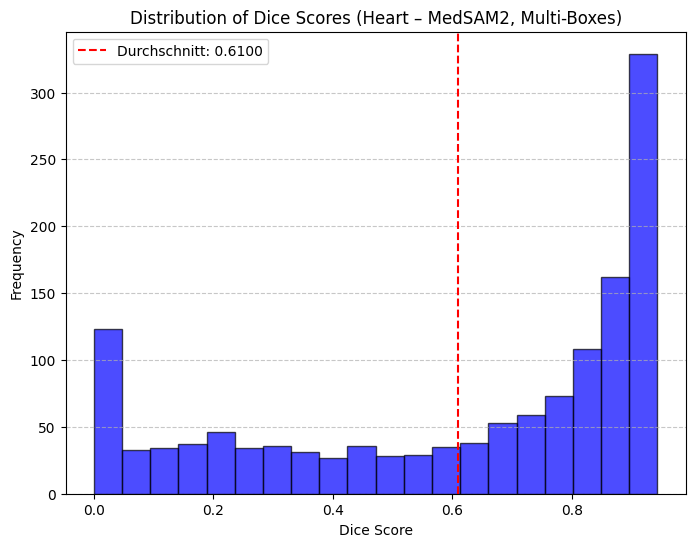

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import logging
import csv
import os

# Ergebnisse + Visualisierung
if dice_scores:
    # CSV speichern
    out_csv = r"F:\Rawan_Masterarbeit\data\Heart\dice_scores_medsam2_central_slice_multi_boxes.csv"
    os.makedirs(os.path.dirname(out_csv), exist_ok=True)
    with open(out_csv, "w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(["Maskenname", "Dice Score"])
        writer.writerows(dice_scores)

    # Durchschnitt berechnen
    dice_values = [score for _, score in dice_scores]
    avg_dice = np.mean(dice_values)
    logging.info(f"\nDurchschnittlicher Dice Score: {avg_dice:.4f}")

    # Histogramm
    plt.figure(figsize=(8, 6))
    plt.hist(dice_values, bins=20, color='blue', alpha=0.7, edgecolor='black')
    plt.title('Distribution of Dice Scores (Heart – MedSAM2, Multi-Boxes)')
    plt.xlabel('Dice Score')
    plt.ylabel('Frequency')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Durchschnitt markieren
    plt.axvline(avg_dice, color='red', linestyle='dashed', linewidth=1.5, label=f'Durchschnitt: {avg_dice:.4f}')
    plt.legend()

    # Plot speichern + anzeigen
    out_png = r"F:\Rawan_Masterarbeit\data\Heart\dice_score_histogram_medsam2_central_slice_multi_boxes.png"
    plt.savefig(out_png)
    plt.show()

else:
    logging.info("Keine Dice Scores berechnet!")


In [10]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from skimage import transform
from skimage.measure import label, regionprops
import torch
import gc
from tqdm import tqdm
import logging

# MedSAM2 Imports
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

# Logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Visualisierung
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([251 / 255, 252 / 255, 30 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor="blue", facecolor=(0, 0, 0, 0), lw=2))

# Mehrere Bounding Boxes aus einer 2D-Maske (ohne Padding!)
def get_bounding_boxes_from_mask(mask2d, H, W):
    boxes = []
    lab = label(mask2d.astype(np.uint8))
    for r in regionprops(lab):
        minr, minc, maxr, maxc = r.bbox  # (row, col)
        boxes.append([minc, minr, maxc, maxr])   # [x_min, y_min, x_max, y_max]
    return boxes

# Gerät
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.info(f"Verwende Gerät: {device}")

# Modell laden
medsam_model = build_sam2(
    config_file="configs/sam2.1_hiera_t512.yaml",
    ckpt_path="checkpoints/MedSAM2_2411.pt",
    device=device
)
predictor = SAM2ImagePredictor(medsam_model)
logging.info("MedSAM2 model loaded successfully.")

# Hauptfunktion: NUR mittlere Slice liefert mehrere Boxes, die für alle Slices benutzt werden
@torch.no_grad()
def process_images_with_propagation(images_dir, masks_dir, output_dir, resume_file=None, save_png=True):
    resume = resume_file is None
    mask_files = sorted([f for f in os.listdir(masks_dir) if f.endswith(".nii") or f.endswith(".nii.gz")])

    with tqdm(total=len(mask_files), desc="Dateien", unit="Datei") as progress:
        for mask_file in mask_files:
            mask_path  = os.path.join(masks_dir,  mask_file)
            image_path = os.path.join(images_dir, mask_file)

            if not os.path.exists(image_path):
                logging.warning(f"Fehlendes Bild für Maske: {mask_file}")
                progress.update(1); continue

            if not resume and mask_file == resume_file:
                resume = True
            if not resume:
                progress.update(1); continue

            # NIfTI laden
            nifti_image = nib.load(image_path)
            nifti_mask  = nib.load(mask_path)
            image_data  = nifti_image.get_fdata()  # (H,W,Z)
            mask_data   = nifti_mask.get_fdata()

            H, W, Z = image_data.shape

            # Mittlere Slice (Indexmitte). Falls dort kein Label vorhanden: Fallback = größte Fläche.
            central_slice_idx = Z // 2
            if np.sum(mask_data[:, :, central_slice_idx] > 0) == 0:
                slice_areas = [np.sum(mask_data[:, :, s] > 0) for s in range(Z)]
                central_slice_idx = int(np.argmax(slice_areas))
                logging.info(f"{mask_file}: Mitte leer → nutze Slice mit größter Fläche: {central_slice_idx}")
            else:
                logging.info(f"{mask_file}: zentrale Slice (Index): {central_slice_idx}")

            # Mehrere Bounding Boxes nur aus der mittleren Slice holen (ohne Padding!)
            seed_mask   = (mask_data[:, :, central_slice_idx] > 0).astype(np.uint8)
            boxes_xyxy  = get_bounding_boxes_from_mask(seed_mask, H, W)

            if not boxes_xyxy:
                logging.warning(f"{mask_file}: keine Bounding Boxes in Seed-Slice gefunden – übersprungen.")
                progress.update(1); continue

            # Vorbereiten: Bild-Volumen auf 1024 normalisieren
            image_volume = []
            for z in range(Z):
                img_resized = transform.resize(image_data[:, :, z], (1024, 1024),
                                               order=3, preserve_range=True, anti_aliasing=True)
                img_norm = (img_resized - img_resized.min()) / (img_resized.max() - img_resized.min() + 1e-8)
                image_volume.append(np.stack([img_norm] * 3, axis=-1).astype(np.float32))
            image_volume = np.array(image_volume, dtype=np.float32)

            # Boxen in 1024-Koordinaten vorbereiten
            scale = np.array([W, H, W, H], dtype=np.float32)
            boxes_1024 = []
            for (x1, y1, x2, y2) in boxes_xyxy:
                b = (np.array([x1, y1, x2, y2], dtype=np.float32) / scale) * 1024.0
                boxes_1024.append(b[None, :])  # (1,4)

            # 3D Segmentierung: dieselben (mehreren) Boxes für jede Slice anwenden
            mask_3d = []
            for z in range(Z):
                predictor.set_image((image_volume[z] * 255).astype(np.uint8))
                combined = np.zeros((1024, 1024), dtype=np.uint8)
                for b in boxes_1024:
                    seg = predictor.predict(box=b, multimask_output=False)[0]
                    seg = np.squeeze(seg).astype(np.uint8)
                    combined = np.maximum(combined, seg)
                mask_3d.append(combined)
            mask_3d = np.array(mask_3d, dtype=np.uint8)  # (Z,1024,1024)

            # Ergebnisse speichern
            case_out_dir = os.path.join(output_dir, mask_file.replace(".nii.gz", "").replace(".nii", ""))
            os.makedirs(case_out_dir, exist_ok=True)

            # PNG-Slices optional speichern
            if save_png:
                for z in range(Z):
                    png_path = os.path.join(case_out_dir, f"slice_{z}_segmentation.png")
                    plt.imsave(png_path, mask_3d[z], cmap="gray")

                # Visualisierung des zentralen Slice
                vis_file = os.path.join(case_out_dir, f"central_slice_{central_slice_idx}_visualization.png")
                fig, ax = plt.subplots(1, 2, figsize=(12, 6))
                ax[0].imshow(image_volume[central_slice_idx][:, :, 0], cmap="gray")
                for b in boxes_1024:
                    show_box(b[0], ax[0])
                ax[0].set_title(f"Seed-Slice {central_slice_idx} mit Bounding Boxes")
                ax[0].set_aspect('equal')
                ax[1].imshow(image_volume[central_slice_idx][:, :, 0], cmap="gray")
                show_mask(mask_3d[central_slice_idx], ax[1])
                ax[1].set_title("Segmentierung (Seed-Slice)")
                ax[1].set_aspect('equal')
                plt.savefig(vis_file); plt.close(fig)

            # Maske als NIfTI speichern
            nifti_out = nib.Nifti1Image(mask_3d.astype(np.uint8), affine=nifti_image.affine)
            nib.save(nifti_out, os.path.join(case_out_dir, "segmentation_3d.nii.gz"))

            del mask_3d, image_volume
            gc.collect()

            logging.info(f"Done with file {mask_file}")
            progress.update(1)

# Ordner definieren (HEART!)
images_dir = r"F:\Rawan_Masterarbeit\data\Heart\output_images"
masks_dir  = r"F:\Rawan_Masterarbeit\data\Heart\output_masks"
output_dir = r"F:\Rawan_Masterarbeit\data\Heart\MedSAM2_results_3seeds"
os.makedirs(output_dir, exist_ok=True)

# Starten
process_images_with_propagation(
    images_dir=images_dir,
    masks_dir=masks_dir,
    output_dir=output_dir,
    resume_file="la_003.nii.gz",   # oder None
    save_png=True
)


2025-08-16 16:01:55,816 - INFO - Verwende Gerät: cpu
2025-08-16 16:01:55,819 - INFO - Using device: cpu
2025-08-16 16:02:01,448 - INFO - Loaded checkpoint sucessfully
2025-08-16 16:02:01,700 - INFO - MedSAM2 model loaded successfully.
Dateien:   0%|                                                                               | 0/20 [00:00<?, ?Datei/s]2025-08-16 16:02:02,295 - INFO - la_003.nii.gz: zentrale Slice (Index): 33
2025-08-16 16:02:14,983 - INFO - For numpy array image, we assume (HxWxC) format
2025-08-16 16:02:16,081 - INFO - Computing image embeddings for the provided image...
2025-08-16 16:02:18,265 - INFO - Image embeddings computed.
2025-08-16 16:02:19,011 - INFO - For numpy array image, we assume (HxWxC) format
2025-08-16 16:02:19,056 - INFO - Computing image embeddings for the provided image...
2025-08-16 16:02:20,371 - INFO - Image embeddings computed.
2025-08-16 16:02:20,481 - INFO - For numpy array image, we assume (HxWxC) format
2025-08-16 16:02:20,513 - INFO - Com

KeyboardInterrupt: 

In [11]:
# --------------------------------------------------------
# MedSAM2 – 3 Seeds (erste, mittlere, letzte Slice)
#   • Boxes aus allen drei Seed-Slices (OHNE Padding)
#   • Segmentierung nutzt alle Seeds
#   • Visualisierung zeigt nur die mittleren Seed-Boxen
# --------------------------------------------------------
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from skimage import transform
from skimage.measure import label, regionprops
import torch
import gc
from tqdm import tqdm
import logging

# MedSAM2
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

# ---------- Logging ----------
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# ---------- Helpers ----------
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([251/255, 252/255, 30/255, 0.6])
    h, w = mask.shape[-2:]
    ax.imshow(mask.reshape(h, w, 1) * color.reshape(1, 1, -1))

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h   = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor="blue",
                               facecolor=(0,0,0,0), lw=2))

def get_bounding_boxes_from_mask(mask2d):
    """Boxes exakt entlang der Maske (OHNE Padding).
       Rückgabe: Liste [x_min, y_min, x_max, y_max] in Original-Koordinaten.
    """
    boxes = []
    lab = label(mask2d.astype(np.uint8))
    for r in regionprops(lab):
        minr, minc, maxr, maxc = r.bbox  # (row, col)
        boxes.append([minc, minr, maxc, maxr])
    return boxes

@torch.no_grad()
def predict_with_boxes(predictor, image_rgb_1024, boxes1024_list):
    """Setzt einmal das Bild, läuft dann alle Boxen durch und vereinigt die Masken."""
    predictor.set_image((image_rgb_1024 * 255).astype(np.uint8))
    combined = np.zeros((1024, 1024), dtype=np.uint8)
    for b in boxes1024_list:
        seg = predictor.predict(box=b, multimask_output=False)[0]
        seg = np.squeeze(seg).astype(np.uint8)
        combined = np.maximum(combined, seg)
    return combined

# ---------- Gerät & Modell ----------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.info(f"Verwende Gerät: {device}")

medsam_model = build_sam2(
    config_file="configs/sam2.1_hiera_t512.yaml",
    ckpt_path="checkpoints/MedSAM2_2411.pt",
    device=device
)
predictor = SAM2ImagePredictor(medsam_model)
logging.info("MedSAM2 model loaded successfully.")

# ---------- Hauptfunktion ----------
@torch.no_grad()
def process_images_with_propagation_3seeds(images_dir, masks_dir, output_dir, resume_file=None, save_png=True):
    """Verwendet erste, mittlere und letzte Slice als Seeds (mehrere Boxes möglich, ohne Padding)."""
    os.makedirs(output_dir, exist_ok=True)
    cases = sorted([f for f in os.listdir(masks_dir) if f.endswith(".nii") or f.endswith(".nii.gz")])

    resume = resume_file is None
    with tqdm(total=len(cases), desc="Fälle", unit="Fall") as pbar:
        for case in cases:
            if not resume and case == resume_file:
                resume = True
            if not resume:
                pbar.update(1); continue

            img_path  = os.path.join(images_dir, case)
            mask_path = os.path.join(masks_dir,  case)
            if not os.path.exists(img_path):
                logging.warning(f"Fehlendes Bild für Maske: {case}")
                pbar.update(1); continue

            # --- Load ---
            nii_img = nib.load(img_path)
            nii_gt  = nib.load(mask_path)
            vol_img = nii_img.get_fdata()   # (H,W,Z)
            vol_msk = nii_gt.get_fdata()
            H, W, Z = vol_img.shape

            # --- Seeds: erste, mittlere, letzte ---
            mid = Z // 2
            seed_indices = [0, mid, Z-1]

            # --- Boxes je Seed sammeln (ohne Padding) ---
            boxes_by_seed = {}
            for idx in seed_indices:
                seed_mask = (vol_msk[:, :, idx] > 0).astype(np.uint8)
                boxes = get_bounding_boxes_from_mask(seed_mask)
                if boxes:
                    boxes_by_seed[idx] = boxes
                    logging.info(f"{case}: {len(boxes)} Box(en) in Seed-Slice {idx}")

            if not boxes_by_seed:
                logging.warning(f"{case}: keine Bounding Boxes in (0, Mitte, letzte) – übersprungen.")
                pbar.update(1); continue

            # Für die Darstellung: nur mittlere Boxen, wenn vorhanden; sonst die eines vorhandenen Seeds
            vis_seed = mid if mid in boxes_by_seed else sorted(boxes_by_seed.keys())[0]
            vis_boxes_xyxy = boxes_by_seed[vis_seed]

            # --- Volumen → 1024-Format vorbereiten ---
            image_volume = []
            for z in range(Z):
                img = vol_img[:, :, z]
                img1024 = transform.resize(img, (1024, 1024), order=3, preserve_range=True, anti_aliasing=True)
                img1024 = (img1024 - img1024.min()) / (img1024.max() - img1024.min() + 1e-8)
                image_volume.append(np.stack([img1024]*3, axis=-1).astype(np.float32))
            image_volume = np.array(image_volume, dtype=np.float32)

            # --- Alle Seed-Boxen in 1024-Koordinaten umrechnen (für Segmentation) ---
            scale = np.array([W, H, W, H], dtype=np.float32)
            boxes1024_all = []
            for seed_idx, boxes in boxes_by_seed.items():
                for (x1, y1, x2, y2) in boxes:
                    b = (np.array([x1, y1, x2, y2], dtype=np.float32) / scale) * 1024.0
                    boxes1024_all.append(b[None, :])   # (1,4)

            # --- Nur mittlere (oder Fallback-) Boxen für Visualisierung ---
            boxes1024_vis = []
            for (x1, y1, x2, y2) in vis_boxes_xyxy:
                b = (np.array([x1, y1, x2, y2], dtype=np.float32) / scale) * 1024.0
                boxes1024_vis.append(b)               # (4,)

            # --- Segmentieren (alle Seeds) ---
            seg_3d = np.zeros((Z, 1024, 1024), dtype=np.uint8)
            for z in range(Z):
                seg_3d[z] = predict_with_boxes(predictor, image_volume[z], boxes1024_all)

            # --- Speichern ---
            case_out = os.path.join(output_dir, case.replace(".nii.gz", "").replace(".nii", ""))
            os.makedirs(case_out, exist_ok=True)

            # PNGs
            if save_png:
                for z in range(Z):
                    plt.imsave(os.path.join(case_out, f"slice_{z}_segmentation.png"), seg_3d[z], cmap="gray")

                # Visualisierung (nur mittlere Seed-Boxen)
                vis_file = os.path.join(case_out, f"seed_slice_{vis_seed}_visualization.png")
                fig, ax = plt.subplots(1, 2, figsize=(12, 6))
                ax[0].imshow(image_volume[vis_seed][:, :, 0], cmap="gray"); ax[0].set_aspect('equal')
                for b in boxes1024_vis:
                    show_box(b, ax[0])
                ax[0].set_title("Seeds (nur mittlere Slice Boxen)" if vis_seed == mid else f"Seeds (Slice {vis_seed})")
                ax[1].imshow(image_volume[vis_seed][:, :, 0], cmap="gray"); ax[1].set_aspect('equal')
                show_mask(seg_3d[vis_seed], ax[1])
                ax[1].set_title("Segmentierung (Propagation)")
                plt.savefig(vis_file, dpi=150, bbox_inches="tight"); plt.close(fig)

            # NIfTI
            nib.save(nib.Nifti1Image(seg_3d.astype(np.uint8), affine=nii_img.affine),
                     os.path.join(case_out, "segmentation_3seeds.nii.gz"))

            # Cleanup
            del seg_3d, image_volume
            gc.collect()
            pbar.update(1)
            logging.info(f"Fertig: {case}")

# ---------- Aufruf (HEART) ----------
images_dir = r"F:\Rawan_Masterarbeit\data\Heart\output_images"
masks_dir  = r"F:\Rawan_Masterarbeit\data\Heart\output_masks"
output_dir = r"F:\Rawan_Masterarbeit\data\Heart\MedSAM2_results_3seeds"
os.makedirs(output_dir, exist_ok=True)


# Starten
process_images_with_propagation_3seeds(
    images_dir=images_dir,
    masks_dir=masks_dir,
    output_dir=output_dir,
    resume_file="la_003.nii.gz",   # oder None
    save_png=True
)

2025-08-16 16:09:36,076 - INFO - Verwende Gerät: cpu
2025-08-16 16:09:36,078 - INFO - Using device: cpu
2025-08-16 16:09:41,581 - INFO - Loaded checkpoint sucessfully
2025-08-16 16:09:41,893 - INFO - MedSAM2 model loaded successfully.
Fälle:   0%|                                                                                  | 0/20 [00:00<?, ?Fall/s]2025-08-16 16:09:42,734 - INFO - la_003.nii.gz: 1 Box(en) in Seed-Slice 0
2025-08-16 16:09:42,741 - INFO - la_003.nii.gz: 1 Box(en) in Seed-Slice 33
2025-08-16 16:09:42,745 - INFO - la_003.nii.gz: 2 Box(en) in Seed-Slice 65
2025-08-16 16:09:59,938 - INFO - For numpy array image, we assume (HxWxC) format
2025-08-16 16:10:02,109 - INFO - Computing image embeddings for the provided image...
2025-08-16 16:10:07,994 - INFO - Image embeddings computed.
2025-08-16 16:10:09,124 - INFO - For numpy array image, we assume (HxWxC) format
2025-08-16 16:10:09,165 - INFO - Computing image embeddings for the provided image...
2025-08-16 16:10:10,807 - IN

In [12]:
import os
import numpy as np
import cv2
import logging
import csv
from concurrent.futures import ThreadPoolExecutor

# Logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Ordner mit GT (Ground Truth PNGs)  ⬅️ passe an, falls dein GT woanders liegt
gt_dir = r"F:\Rawan_Masterarbeit\data\Heart\output_masks_updated"

# Ordner mit Predictions (MedSAM2: zentrale Slice, mehrere Boxes → pro Case Unterordner)
pred_root = r"F:\Rawan_Masterarbeit\data\Heart\MedSAM2_results_3seeds"

def dice_score(mask1, mask2):
    intersection = np.sum(mask1 * mask2)
    s = np.sum(mask1) + np.sum(mask2)
    return 1.0 if s == 0 else (2.0 * intersection) / s

def process_single_file(gt_filename):
    """
    Erwartetes GT-Muster: <case>_slice_<NN>_segmentation.png
    Beispiel: la_003_slice_01_segmentation.png
    Prediction: pred_root/<case>/slice_<N-1>_segmentation.png
    """
    if "_slice_" not in gt_filename:
        return None

    parts = gt_filename.split("_slice_")
    case_name = parts[0]                     # z.B. "la_003"
    slice_part = parts[1]                    # z.B. "01_segmentation.png"
    slice_num_str = slice_part.split("_")[0] # "01"
    try:
        slice_num_gt = int(slice_num_str)    # 1-basiert
    except ValueError:
        logging.warning(f"Konnte Slice-Zahl nicht parsen: {gt_filename}")
        return None

    slice_num_pred = slice_num_gt - 1        # 0-basiert für Predictions

    # Pfade bauen
    gt_path  = os.path.join(gt_dir, gt_filename)
    pred_path = os.path.join(pred_root, case_name, f"slice_{slice_num_pred}_segmentation.png")

    if not os.path.exists(pred_path):
        logging.warning(f"Prediction nicht gefunden: {pred_path}")
        return None

    # Laden
    gt_mask   = cv2.imread(gt_path,  cv2.IMREAD_GRAYSCALE)
    pred_mask = cv2.imread(pred_path, cv2.IMREAD_GRAYSCALE)
    if gt_mask is None or pred_mask is None:
        logging.warning(f"Konnte Datei nicht lesen: {gt_path} oder {pred_path}")
        return None

    # Binär
    gt_mask   = (gt_mask > 0).astype(np.uint8)
    pred_mask = (pred_mask > 0).astype(np.uint8)

    # Größen angleichen (Prediction → GT-Größe)
    if gt_mask.shape != pred_mask.shape:
        pred_mask = cv2.resize(pred_mask, (gt_mask.shape[1], gt_mask.shape[0]), interpolation=cv2.INTER_NEAREST)

    # Dice
    dice = dice_score(gt_mask, pred_mask)
    logging.info(f"{gt_filename}: Dice Score = {dice:.4f}")
    return gt_filename, dice

# Parallelisierte Verarbeitung
with ThreadPoolExecutor() as executor:
    futures = [executor.submit(process_single_file, f)
               for f in os.listdir(gt_dir) if f.lower().endswith(".png")]
    dice_scores = [res for res in (f.result() for f in futures) if res is not None]

# Ergebnisse speichern & Durchschnitt
if dice_scores:
    out_csv = r"F:\Rawan_Masterarbeit\data\Heart\dice_scores_medsam2_3seeds.csv"
    os.makedirs(os.path.dirname(out_csv), exist_ok=True)
    with open(out_csv, "w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(["GT Filename", "Dice Score"])
        writer.writerows(dice_scores)

    mean_dice = np.mean([score for _, score in dice_scores])
    logging.info(f"Durchschnittlicher Dice Score: {mean_dice:.4f}")
else:
    logging.info("Keine Dice Scores berechnet!")


2025-08-16 17:11:18,780 - INFO - la_003_slice_05_segmentation.png: Dice Score = 0.0998
2025-08-16 17:11:18,802 - INFO - la_003_slice_02_segmentation.png: Dice Score = 0.0370
2025-08-16 17:11:18,830 - INFO - la_003_slice_03_segmentation.png: Dice Score = 0.0396
2025-08-16 17:11:18,819 - INFO - la_003_slice_01_segmentation.png: Dice Score = 0.0406
2025-08-16 17:11:18,824 - INFO - la_003_slice_06_segmentation.png: Dice Score = 0.0319
2025-08-16 17:11:18,901 - INFO - la_003_slice_09_segmentation.png: Dice Score = 0.6166
2025-08-16 17:11:18,817 - INFO - la_003_slice_04_segmentation.png: Dice Score = 0.0587
2025-08-16 17:11:18,848 - INFO - la_003_slice_08_segmentation.png: Dice Score = 0.5521
2025-08-16 17:11:18,825 - INFO - la_003_slice_07_segmentation.png: Dice Score = 0.4809
2025-08-16 17:11:18,995 - INFO - la_003_slice_13_segmentation.png: Dice Score = 0.7458
2025-08-16 17:11:19,016 - INFO - la_003_slice_15_segmentation.png: Dice Score = 0.7625
2025-08-16 17:11:19,024 - INFO - la_003_sli

2025-08-16 17:12:26,527 - INFO - 
Durchschnittlicher Dice Score: 0.6801


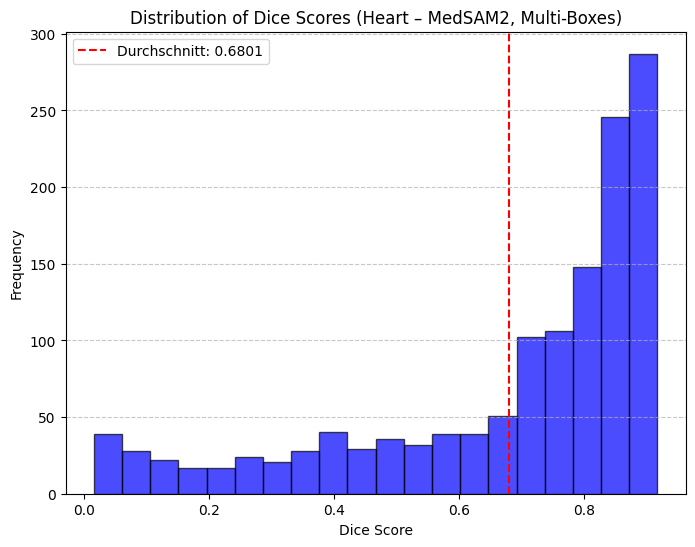

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import logging
import csv
import os

# Ergebnisse + Visualisierung
if dice_scores:
    # CSV speichern
    out_csv = r"F:\Rawan_Masterarbeit\data\Heart\dice_scores_medsam2_3seeds.csv"
    os.makedirs(os.path.dirname(out_csv), exist_ok=True)
    with open(out_csv, "w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(["Maskenname", "Dice Score"])
        writer.writerows(dice_scores)

    # Durchschnitt berechnen
    dice_values = [score for _, score in dice_scores]
    avg_dice = np.mean(dice_values)
    logging.info(f"\nDurchschnittlicher Dice Score: {avg_dice:.4f}")

    # Histogramm
    plt.figure(figsize=(8, 6))
    plt.hist(dice_values, bins=20, color='blue', alpha=0.7, edgecolor='black')
    plt.title('Distribution of Dice Scores (Heart – MedSAM2, Multi-Boxes)')
    plt.xlabel('Dice Score')
    plt.ylabel('Frequency')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Durchschnitt markieren
    plt.axvline(avg_dice, color='red', linestyle='dashed', linewidth=1.5, label=f'Durchschnitt: {avg_dice:.4f}')
    plt.legend()

    # Plot speichern + anzeigen
    out_png = r"F:\Rawan_Masterarbeit\data\Heart\dice_score_histogram_medsam2_3seeds.png"
    plt.savefig(out_png)
    plt.show()

else:
    logging.info("Keine Dice Scores berechnet!")


In [4]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from skimage import transform
from skimage.measure import label, regionprops
import torch
import gc
from tqdm import tqdm
import logging

from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

# Logging aktivieren
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Maske anzeigen
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([251 / 255, 252 / 255, 30 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

# Box anzeigen
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor="blue", facecolor=(0, 0, 0, 0), lw=2))

# Mehrere Bounding Boxes aus Maske extrahieren
def get_bounding_boxes_from_mask(mask):
    labeled_mask = label(mask)
    boxes = []
    for region in regionprops(labeled_mask):
        minr, minc, maxr, maxc = region.bbox
        boxes.append([minc, minr, maxc, maxr])  # [x_min, y_min, x_max, y_max]
    return boxes

# Inferenz mit MedSAM2 für eine einzelne Box
@torch.no_grad()
def medsam2_inference(predictor, image_rgb, box_1024):
    predictor.set_image((image_rgb * 255).astype(np.uint8))
    masks, scores, logits = predictor.predict(
        box=box_1024,
        multimask_output=False
    )
    return masks[0].astype(np.uint8)

# Gerät auswählen
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.info(f"Verwende Gerät: {device}")

# Modell laden
medsam_model = build_sam2(
    config_file="configs/sam2.1_hiera_t512.yaml",
    ckpt_path="checkpoints/MedSAM2_2411.pt",
    device=device
)
predictor = SAM2ImagePredictor(medsam_model)
logging.info("MedSAM2 model loaded successfully.")

# Segmentierung
def process_images_and_masks_with_resume(images_dir, masks_dir, output_dir, resume_file=None, resume_slice=None):
    resume = resume_file is None
    mask_files = sorted(os.listdir(masks_dir))

    with tqdm(total=len(mask_files), desc="Dateien", unit="Datei") as progress:
        for mask_file in mask_files:
            mask_path = os.path.join(masks_dir, mask_file)
            image_path = os.path.join(images_dir, mask_file)

            if not os.path.exists(image_path):
                logging.warning(f"Fehlendes Bild für Maske: {mask_file}")
                progress.update(1)
                continue

            if not resume and mask_file == resume_file:
                resume = True
            if not resume:
                progress.update(1)
                continue

            nifti_image = nib.load(image_path)
            nifti_mask = nib.load(mask_path)
            image_data = nifti_image.get_fdata()
            mask_data = nifti_mask.get_fdata()
            total_slices = image_data.shape[2]
            slice_start = resume_slice if mask_file == resume_file and resume_slice is not None else 0

            with tqdm(total=total_slices, desc=f"Slices in {mask_file}", unit="Slice") as slice_progress:
                for slice_idx in range(slice_start, total_slices):
                    logging.info(f"Verarbeite Slice {slice_idx} für Datei {mask_file}")
                    image_slice = image_data[:, :, slice_idx]
                    mask_slice = mask_data[:, :, slice_idx]

                    if np.sum(mask_slice) == 0:
                        slice_progress.update(1)
                        continue

                    boxes = get_bounding_boxes_from_mask(mask_slice)
                    H, W = image_slice.shape
                    resized_image = transform.resize(image_slice, (1024, 1024), order=3, preserve_range=True, anti_aliasing=True)
                    normalized_image = (resized_image - resized_image.min()) / max(resized_image.max() - resized_image.min(), 1e-8)
                    image_rgb = np.stack([normalized_image] * 3, axis=-1)

                    combined_seg = np.zeros((1024, 1024), dtype=np.uint8)

                    for box in boxes:
                        box_np = np.array(box)
                        box_1024 = box_np / np.array([W, H, W, H]) * 1024
                        seg = medsam2_inference(predictor, image_rgb, box_1024)
                        combined_seg = np.maximum(combined_seg, seg)

                    visualization_file = os.path.join(output_dir, f"{mask_file}_slice_{slice_idx}_visualization.png")
                    seg_file = os.path.join(output_dir, f"{mask_file}_slice_{slice_idx}_segmentation.png")

                    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
                    ax[0].imshow(resized_image, cmap="gray")
                    for box in boxes:
                        box_1024 = np.array(box) / np.array([W, H, W, H]) * 1024
                        show_box(box_1024, ax[0])
                    ax[0].set_title(f"Original Slice {slice_idx} mit Bounding Boxes")
                    ax[1].imshow(resized_image, cmap="gray")
                    show_mask(combined_seg, ax[1])
                    ax[1].set_title(f"Segmentierung Slice {slice_idx}")
                    plt.savefig(visualization_file)
                    plt.close(fig)

                    plt.imsave(seg_file, combined_seg, cmap="gray")
                    gc.collect()
                    slice_progress.update(1)

            logging.info(f"Fertig mit Datei {mask_file}")
            progress.update(1)

# Verzeichnisse definieren
images_dir = r"F:\Rawan_Masterarbeit\data\Heart\output_images"
masks_dir = r"F:\Rawan_Masterarbeit\data\Heart\output_masks"
output_dir = r"F:\Rawan_Masterarbeit\data\Heart\segmentation_results_medsam2"
os.makedirs(output_dir, exist_ok=True)

process_images_and_masks_with_resume(
    images_dir=images_dir,
    masks_dir=masks_dir,
    output_dir=output_dir,
    resume_file="la_030.nii.gz",
    resume_slice=60
)


2025-07-04 18:23:08,163 - INFO - Verwende Gerät: cpu
2025-07-04 18:23:08,163 - INFO - Using device: cpu
2025-07-04 18:23:09,142 - INFO - Loaded checkpoint sucessfully
2025-07-04 18:23:09,241 - INFO - MedSAM2 model loaded successfully.
Slices in la_030.nii.gz:   0%|                                                               | 0/69 [00:00<?, ?Slice/s]2025-07-04 18:23:10,255 - INFO - Verarbeite Slice 60 für Datei la_030.nii.gz
2025-07-04 18:23:10,388 - INFO - For numpy array image, we assume (HxWxC) format
2025-07-04 18:23:10,457 - INFO - Computing image embeddings for the provided image...
2025-07-04 18:23:11,409 - INFO - Image embeddings computed.
2025-07-04 18:23:11,497 - INFO - For numpy array image, we assume (HxWxC) format
2025-07-04 18:23:11,527 - INFO - Computing image embeddings for the provided image...
2025-07-04 18:23:12,440 - INFO - Image embeddings computed.

Slices in la_030.nii.gz:   1%|▊                                                      | 1/69 [00:04<05:10,  4.57s/S

In [2]:
# -*- coding: utf-8 -*-
import os
import json
import time
import csv
import gc
import logging
from typing import Optional, Tuple, List

import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from skimage import transform
from skimage.measure import label, regionprops
from tqdm import tqdm
import torch

# =============== MedSAM2 Imports ===============
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

# ========================= Logging =========================
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# =================== Visualisierungsfunktionen ===================
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([251 / 255, 252 / 255, 30 / 255, 0.6])  # Gelb mit Transparenz
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor="blue", facecolor=(0, 0, 0, 0), lw=2))

def get_bounding_boxes_from_mask(mask_2d: np.ndarray) -> List[List[int]]:
    """
    Liefert Liste von [x_min, y_min, x_max, y_max] Boxen für alle Komponenten >0.
    """
    labeled_mask = label(mask_2d)
    boxes = []
    for region in regionprops(labeled_mask):
        minr, minc, maxr, maxc = region.bbox
        boxes.append([int(minc), int(minr), int(maxc), int(maxr)])
    return boxes

# =================== Gerät & Modell ===================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.info(f"Verwende Gerät: {device}")

medsam2_model = build_sam2(
    config_file="configs/sam2.1_hiera_t512.yaml",
    # Pfad anpassen:
    ckpt_path=r"F:\Rawan_Masterarbeit\MedSAM2_old\checkpoints\MedSAM2_2411.pt",
    device=device
)
predictor = SAM2ImagePredictor(medsam2_model)
logging.info("MedSAM2 Modell erfolgreich geladen.")

# =================== Helpers: Zeit/CSV/Runtime-State ===================
def _fmt(sec: float) -> str:
    h, r = divmod(sec, 3600)
    m, s = divmod(r, 60)
    return f"{int(h):02d}:{int(m):02d}:{s:05.2f}"

def _sum_seconds_from_csv(csv_path: str) -> float:
    if not os.path.exists(csv_path):
        return 0.0
    total = 0.0
    try:
        with open(csv_path, "r", encoding="utf-8") as f:
            reader = csv.DictReader(f)
            if not reader.fieldnames or "seconds" not in reader.fieldnames:
                return 0.0
            for row in reader:
                try:
                    total += float(row["seconds"])
                except Exception:
                    continue
    except Exception as e:
        logging.warning(f"Konnte CSV nicht auswerten ({csv_path}): {e}")
    return total

def _load_runtime_state(state_path: str) -> dict:
    if os.path.exists(state_path):
        try:
            with open(state_path, "r", encoding="utf-8") as f:
                return json.load(f)
        except Exception as e:
            logging.warning(f"Runtime-State nicht lesbar: {e}")
    return {"sessions": [], "total_elapsed_sec": 0.0}

def _save_runtime_state(state_path: str, state: dict):
    with open(state_path, "w", encoding="utf-8") as f:
        json.dump(state, f, indent=2)

def time_run_accumulate(func, state_path: str, seed_timing_csv: str, *args, **kwargs):
    """
    Führt func aus, misst Laufzeit des aktuellen Runs und akkumuliert in state_path.
    Am Ende zusätzlich die akkumulierte Rechenzeit aus seed_timing_csv (CSV-Summe) loggen.
    """
    state = _load_runtime_state(state_path)
    start = time.perf_counter()
    start_wall = time.time()
    logging.info("==== Starte Laufzeitmessung (akkumuliert) ====")
    try:
        return func(*args, **kwargs)
    finally:
        elapsed = time.perf_counter() - start
        end_wall = time.time()
        state["sessions"].append({"start": start_wall, "end": end_wall, "elapsed_sec": elapsed})
        state["total_elapsed_sec"] = float(state.get("total_elapsed_sec", 0.0)) + float(elapsed)
        _save_runtime_state(state_path, state)

        msg1 = f"Aktueller Run: {_fmt(elapsed)} | Akkumuliert (Wall-Clock): {_fmt(state['total_elapsed_sec'])}"
        logging.info(msg1)
        total_csv_sec = _sum_seconds_from_csv(seed_timing_csv)
        msg2 = f"Akkumulierte Gesamtlaufzeit (aus CSV, alle Neustarts): {_fmt(total_csv_sec)}"
        logging.info(msg2)
        with open("runtime_log_medsam2_heart.txt", "a", encoding="utf-8") as f:
            f.write(msg1 + "\n")
            f.write(msg2 + "\n")

# =================== Resume-Checkpoint ===================
def save_resume_state(checkpoint_path: str, filename: str, slice_idx: int):
    state = {"resume_file": filename, "resume_slice": slice_idx}
    with open(checkpoint_path, "w", encoding="utf-8") as f:
        json.dump(state, f)

def load_resume_state(checkpoint_path: str) -> Tuple[Optional[str], Optional[int]]:
    if os.path.exists(checkpoint_path):
        try:
            with open(checkpoint_path, "r", encoding="utf-8") as f:
                state = json.load(f)
            return state.get("resume_file"), state.get("resume_slice")
        except Exception as e:
            logging.warning(f"Checkpoint nicht lesbar: {e}")
    return None, None

# =================== Inferenz (SAM2) ===================
@torch.no_grad()
def medsam2_predict_for_boxes(
    predictor: SAM2ImagePredictor,
    image_rgb_u8: np.ndarray,
    boxes_1024: np.ndarray
) -> np.ndarray:
    """
    Setzt das Bild EINMAL und inferiert für mehrere Boxen.
    image_rgb_u8: (1024,1024,3) uint8
    boxes_1024:   (N,4) float32 in 1024 Koordinaten [x0,y0,x1,y1]
    """
    predictor.set_image(image_rgb_u8)
    combined = np.zeros((image_rgb_u8.shape[0], image_rgb_u8.shape[1]), dtype=np.uint8)
    for b in boxes_1024:
        masks, scores, logits = predictor.predict(box=b.tolist(), multimask_output=False)
        combined = np.maximum(combined, masks[0].astype(np.uint8))
    return combined

# =================== Pipeline (Heart) ===================
def process_images_and_masks_with_resume(
    images_dir: str,
    masks_dir: str,
    output_dir: str,
    checkpoint_path: str,
    timing_csv: str,
    resume_file: Optional[str] = None,
    resume_slice: Optional[int] = None,
    use_auto_resume: bool = True,
):
    """
    - Segmentiert alle Heart-Volumes sliceweise mit MedSAM2 (Multi-BBox aus GT).
    - Schreibt VOR JEDEM Slice einen Resume-Checkpoint.
    - Hängt pro Slice die Laufzeit an timing_csv an (persistiert über Neustarts).
    """
    os.makedirs(output_dir, exist_ok=True)

    # Auto-Resume
    if use_auto_resume and (resume_file is None and resume_slice is None):
        cf, cs = load_resume_state(checkpoint_path)
        if cf is not None:
            logging.info(f"Automatischer Resume → Datei={cf}, Slice={cs}")
            resume_file, resume_slice = cf, cs

    # timing CSV initialisieren (Header nur einmal)
    if not os.path.exists(timing_csv):
        with open(timing_csv, "w", newline="", encoding="utf-8") as fcsv:
            csv.writer(fcsv).writerow(["file", "slice_idx", "seconds"])

    # Dateiliste (über Masken; Bildnamen identisch erwartet)
    mask_files = sorted([f for f in os.listdir(masks_dir) if f.endswith((".nii", ".nii.gz"))])
    resume_armed = resume_file is None  # erst ab resume_file loslegen

    with tqdm(total=len(mask_files), desc="Dateien", unit="Datei") as prog_files:
        for mask_file in mask_files:
            mask_path = os.path.join(masks_dir, mask_file)
            image_path = os.path.join(images_dir, mask_file)

            if not os.path.exists(image_path):
                logging.warning(f"Fehlendes Bild für Maske: {mask_file}")
                prog_files.update(1)
                continue

            if not resume_armed:
                if mask_file == resume_file:
                    resume_armed = True
                else:
                    prog_files.update(1)
                    continue

            # NIfTI laden
            nifti_image = nib.load(image_path)
            nifti_mask  = nib.load(mask_path)
            image_data = nifti_image.get_fdata()
            mask_data  = nifti_mask.get_fdata()

            if image_data.ndim != 3:
                raise ValueError(f"Erwartet 3D (H×W×S), erhalten shape={image_data.shape} für {mask_file}")

            total_slices = image_data.shape[2]
            slice_start = resume_slice if (mask_file == resume_file and resume_slice is not None) else 0

            with tqdm(total=total_slices, desc=f"Slices in {mask_file}", unit="Slice") as prog_slices:
                for slice_idx in range(slice_start, total_slices):
                    t0 = time.perf_counter()
                    try:
                        # Checkpoint vor Bearbeitung schreiben
                        save_resume_state(checkpoint_path, mask_file, slice_idx)

                        image_slice = image_data[:, :, slice_idx]
                        mask_slice  = mask_data[:, :, slice_idx]

                        # Zeit auch für leere GT-Slices schreiben (Überspringen)
                        if np.sum(mask_slice) == 0:
                            elapsed_slice = time.perf_counter() - t0
                            with open(timing_csv, "a", newline="", encoding="utf-8") as fcsv:
                                csv.writer(fcsv).writerow([mask_file, slice_idx, f"{elapsed_slice:.4f}"])
                            prog_slices.update(1)
                            continue

                        # Multi-Box aus GT
                        boxes = get_bounding_boxes_from_mask(mask_slice)
                        H, W = image_slice.shape

                        # Preprocessing: Resize + robuste Normierung
                        resized_image = transform.resize(
                            image_slice, (1024, 1024), order=3, preserve_range=True, anti_aliasing=True
                        )
                        ptp = resized_image.max() - resized_image.min()
                        normalized_image = (resized_image - resized_image.min()) / max(ptp, 1e-8)
                        image_rgb_u8 = (np.stack([normalized_image]*3, axis=-1) * 255).astype(np.uint8)

                        # Boxen auf 1024 skalieren
                        boxes_np = np.array(boxes, dtype=np.float32)  # (N,4) in [x0,y0,x1,y1] @ orig
                        boxes_1024 = boxes_np / np.array([W, H, W, H], dtype=np.float32) * 1024.0

                        # Inferenz
                        combined_seg = medsam2_predict_for_boxes(predictor, image_rgb_u8, boxes_1024)

                        # Speichern (Visualisierung + Maske)
                        vis_file = os.path.join(output_dir, f"{mask_file}_slice_{slice_idx}_visualization.png")
                        seg_file = os.path.join(output_dir, f"{mask_file}_slice_{slice_idx}_segmentation.png")

                        fig, ax = plt.subplots(1, 2, figsize=(12, 6))
                        ax[0].imshow(resized_image, cmap="gray")
                        for b in boxes_1024:
                            show_box(b, ax[0])
                        ax[0].set_title(f"Original Slice {slice_idx} mit Bounding Boxes")
                        ax[1].imshow(resized_image, cmap="gray")
                        show_mask(combined_seg, ax[1])
                        ax[1].set_title(f"Segmentierung Slice {slice_idx}")
                        plt.savefig(vis_file)
                        plt.close(fig)

                        plt.imsave(seg_file, combined_seg, cmap="gray")

                    except Exception as e:
                        logging.error(f"Fehler bei {mask_file} Slice {slice_idx}: {e}")
                    finally:
                        # Slice-Zeit anhängen (persistiert über alle Runs)
                        elapsed_slice = time.perf_counter() - t0
                        with open(timing_csv, "a", newline="", encoding="utf-8") as fcsv:
                            csv.writer(fcsv).writerow([mask_file, slice_idx, f"{elapsed_slice:.4f}"])

                        # Cleanup
                        gc.collect()
                        if device.type == "cuda":
                            torch.cuda.empty_cache()

                        prog_slices.update(1)

            logging.info(f"Fertig mit Datei {mask_file}")
            prog_files.update(1)

    # Fertig → Checkpoint löschen
    if os.path.exists(checkpoint_path):
        os.remove(checkpoint_path)
        logging.info("Checkpoint entfernt (Pipeline abgeschlossen).")

# =================== AUSFÜHRUNG (Heart) ===================
if __name__ == "__main__":
    # Verzeichnisse definieren (anpassen)
    images_dir = r"F:\Rawan_Masterarbeit\data\Heart\output_images"
    masks_dir  = r"F:\Rawan_Masterarbeit\data\Heart\output_masks"
    output_dir = r"F:\Rawan_Masterarbeit\data\Heart\MedSAM2_results_with_run_time"
    os.makedirs(output_dir, exist_ok=True)

    checkpoint_path = os.path.join(output_dir, "resume_checkpoint.json")
    timing_csv      = os.path.join(output_dir, "timing_per_slice.csv")
    runtime_state   = os.path.join(output_dir, "runtime_state.json")

    # Manuelles Resume (optional). Wenn None/None → Auto-Resume via JSON.
    manual_resume_file  = "la_030.nii.gz"   # z.B. "la_024.nii.gz" oder None
    manual_resume_slice = 40                # z.B. 0 oder None

    # Lauf starten (Wall-Clock akkumuliert + CSV-basierte Gesamtzeit)
    time_run_accumulate(
        process_images_and_masks_with_resume,
        runtime_state,              # state_path
        seed_timing_csv=timing_csv, # <-- Nur für den Wrapper (Summe am Ende)
        images_dir=images_dir,
        masks_dir=masks_dir,
        output_dir=output_dir,
        checkpoint_path=checkpoint_path,
        timing_csv=timing_csv,      # <-- für die Pipeline-Funktion (Pflichtargument)
        resume_file=manual_resume_file,
        resume_slice=manual_resume_slice,
        use_auto_resume=True,
    )

    # Optional: CSV-Gesamtzeit explizit loggen
    total_csv_sec = _sum_seconds_from_csv(timing_csv)
    logging.info(f"[FINAL] Gesamtlaufzeit (CSV über alle Neustarts): {_fmt(total_csv_sec)}")


2025-09-08 18:32:44,169 - INFO - Verwende Gerät: cpu
2025-09-08 18:32:44,170 - INFO - Using device: cpu
2025-09-08 18:32:44,816 - INFO - Loaded checkpoint sucessfully
2025-09-08 18:32:44,860 - INFO - MedSAM2 Modell erfolgreich geladen.
2025-09-08 18:32:44,875 - INFO - ==== Starte Laufzeitmessung (akkumuliert) ====
Slices in la_030.nii.gz:   0%|                                                               | 0/69 [00:00<?, ?Slice/s]2025-09-08 18:32:45,456 - INFO - For numpy array image, we assume (HxWxC) format
2025-09-08 18:32:45,481 - INFO - Computing image embeddings for the provided image...
2025-09-08 18:32:46,254 - INFO - Image embeddings computed.

Slices in la_030.nii.gz:   1%|▊                                                      | 1/69 [00:02<03:14,  2.87s/Slice]2025-09-08 18:32:48,368 - INFO - For numpy array image, we assume (HxWxC) format
2025-09-08 18:32:48,400 - INFO - Computing image embeddings for the provided image...
2025-09-08 18:32:49,251 - INFO - Image embeddings c

In [3]:
import os
import numpy as np
import cv2
import logging
import csv
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor

# Logging konfigurieren
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Ordner mit den Masken
mask_png_folder = os.path.join("F:\Rawan_Masterarbeit","data", "Heart", "output_masks_updated")
segmentation_results_folder = os.path.join("F:\Rawan_Masterarbeit","data", "Heart", "MedSAM2_results_with_run_time")

# Funktion zur Berechnung des Dice Scores
def dice_score(mask1, mask2):
    intersection = np.sum(mask1 * mask2)
    if np.sum(mask1) + np.sum(mask2) == 0:
        return 1.0  # Sonderfall: Beide Masken sind komplett leer
    dice = (2. * intersection) / (np.sum(mask1) + np.sum(mask2))
    return dice

# Funktion zur Verarbeitung einer einzelnen Datei
def process_single_file(mask_filename):
    base_name = mask_filename.split("_slice_")[0]
    slice_number = mask_filename.split("_slice_")[-1].split("_")[0]
    slice_number_converted = int(slice_number) - 1
    segmentation_filename = f"{base_name}.nii.gz_slice_{slice_number_converted}_segmentation.png"

    mask_png_path = os.path.join(mask_png_folder, mask_filename)
    segmentation_path = os.path.join(segmentation_results_folder, segmentation_filename)

    if os.path.exists(segmentation_path):
        try:
            # Masken laden
            mask_png = cv2.imread(mask_png_path, cv2.IMREAD_GRAYSCALE)
            segmentation = cv2.imread(segmentation_path, cv2.IMREAD_GRAYSCALE)

            # Sicherstellen, dass beide Masken binär sind (0 und 1)
            mask_png = (mask_png > 0).astype(np.uint8)
            segmentation = (segmentation > 0).astype(np.uint8)

            # Dice Score berechnen
            dice = dice_score(mask_png, segmentation)
            logging.info(f"{mask_filename}: Dice Score = {dice:.4f}")
            return mask_filename, dice
        except Exception as e:
            logging.error(f"Fehler beim Verarbeiten von {mask_filename}: {e}")
            return None
    else:
        logging.warning(f"Segmentationsdatei für {mask_filename} nicht gefunden!")
        return None

# Parallelisierte Verarbeitung
dice_scores = []
with ThreadPoolExecutor() as executor:
    futures = [executor.submit(process_single_file, mask_filename) for mask_filename in os.listdir(mask_png_folder) if mask_filename.endswith(".png")]
    dice_scores = [future.result() for future in futures if future.result() is not None]


2025-09-08 18:35:06,309 - INFO - la_003_slice_06_segmentation.png: Dice Score = 0.7806
2025-09-08 18:35:06,309 - INFO - la_003_slice_01_segmentation.png: Dice Score = 0.4902
2025-09-08 18:35:06,334 - INFO - la_003_slice_08_segmentation.png: Dice Score = 0.7802
2025-09-08 18:35:06,337 - INFO - la_003_slice_04_segmentation.png: Dice Score = 0.7088
2025-09-08 18:35:06,355 - INFO - la_003_slice_02_segmentation.png: Dice Score = 0.6458
2025-09-08 18:35:06,405 - INFO - la_003_slice_07_segmentation.png: Dice Score = 0.7808
2025-09-08 18:35:06,415 - INFO - la_003_slice_05_segmentation.png: Dice Score = 0.7254
2025-09-08 18:35:06,450 - INFO - la_003_slice_03_segmentation.png: Dice Score = 0.7570
2025-09-08 18:35:06,468 - INFO - la_003_slice_10_segmentation.png: Dice Score = 0.8203
2025-09-08 18:35:06,521 - INFO - la_003_slice_15_segmentation.png: Dice Score = 0.8503
2025-09-08 18:35:06,536 - INFO - la_003_slice_11_segmentation.png: Dice Score = 0.8364
2025-09-08 18:35:06,553 - INFO - la_003_sli

2025-09-08 18:35:31,721 - INFO - 
Durchschnittlicher Dice Score: 0.8292


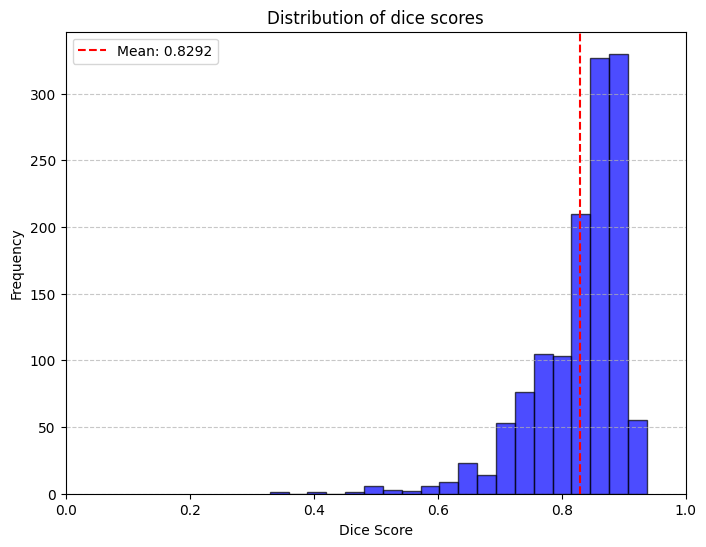

In [4]:
# Ergebnisse speichern und analysieren
if dice_scores:
    # Ergebnisse in CSV speichern
    with open("F:\Rawan_Masterarbeit\data\Heart\dice_scores_medsam2.csv", "w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(["Maskenname", "Dice Score"])
        writer.writerows(dice_scores)

    # Durchschnitt berechnen
    dice_values = [score for _, score in dice_scores]
    avg_dice = np.mean(dice_values)
    logging.info(f"\nDurchschnittlicher Dice Score: {avg_dice:.4f}")

    # Histogramm erstellen
    plt.figure(figsize=(8, 6))
    plt.hist(dice_values, bins=20, color='blue', alpha=0.7, edgecolor='black')
    plt.title('Distribution of dice scores')
    plt.xlabel('Dice Score')
    plt.ylabel('Frequency')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xlim(0, 1)
    plt.ylim(bottom=0)

    # Durchschnitt im Histogramm markieren
    plt.axvline(avg_dice, color='red', linestyle='dashed', linewidth=1.5, label=f'Mean: {avg_dice:.4f}')
    plt.legend()

    # Plot speichern und anzeigen
    plt.savefig('F:\Rawan_Masterarbeit\data\Heart\dice_score_histogram_medsam2_Heart.png')
    plt.show()
else:
    logging.info("Keine Dice Scores berechnet!")
